# Install requirements

In [ ]:
!pip install geopandas shapely pyproj

In [ ]:
!pip install pytrends statsmodels scipy pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends

  Cloning https://github.com/GeneralMills/pytrends to /tmp/pip-req-build-klm12sro
  Running command git clone --filter=blob:none --quiet https://github.com/GeneralMills/pytrends /tmp/pip-req-build-klm12sro
  Resolved https://github.com/GeneralMills/pytrends to commit a9984ffdc9b31d853dde2ab614a77ecbf2bf33a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytrends: filename=pytrends-4.9.2-py3-none-any.whl size=15497 sha256=a068b01ea2e44eacae3fc74b44a1754b870a5c282602685c0b8773e73ff3d818
  Stored in directory: /tmp/pip-ephem-wheel-cache-gx2a2y0f/wheels/2d/b7/b3/ed99bc4c1eead02688423e0034f7e4fa0c317a250ea27304b3
Successfully built pytrends


# Imports

In [ ]:
# Geometry
from shapely.geometry import Point
from shapely.geometry import Polygon

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from IPython.display import display

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pandas.io.json import json_normalize
import numpy as np
from google.colab import drive
from pytrends.request import TrendReq
import time

# Models
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.tsa.stattools as smt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
# Read Data
archivo_xlsx = '/content/drive/MyDrive/Diversa/PUCE/base suicidios.xlsx'
df1 = pd.read_excel(archivo_xlsx)

# Read Ecuador's provinces Shape file
ecu_shp = gpd.read_file("/content/drive/MyDrive/Diversa/PUCE/shp_Ecuador/nxprovincias.shp")
if ecu_shp.crs is None:
    ecu_shp.crs = 'epsg:32717'
ecu_shp = ecu_shp.to_crs('epsg:4326')
ecu_shp = ecu_shp[['DPA_PROVIN', 'geometry']]

In [ ]:
df1.head()

,provincia,fuente1,sexo,año_f,mes_fall,mes_fall1,edad,cod_eda,cau,cau1d,cau2d,cau3d,año,edad2,n,cie10_des,GBD,FECHA
0,02 Bolívar,EDG_2011,Mujer,2011,7,7,26,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,26,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-07-28
1,02 Bolívar,EDG_2011,Hombre,2011,8,8,23,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,23,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-08-28
2,18 Tungurahua,EDG_2012,Mujer,2012,6,6,14,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,14,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-06-28
3,16 Pastaza,EDG_2012,Hombre,2012,2,2,21,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,21,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28
4,16 Pastaza,EDG_2012,Hombre,2012,2,2,34,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,34,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28


# Data cleansing and preparation

In [ ]:
## Subset & clean names/labels

# Rename
column_names_in_english = {
    'provincia': 'province',
    'sexo': 'gender',
    'edad': 'age',
    'cie10_des': 'description',
    'FECHA': 'date'
}
df1.rename(columns=column_names_in_english, inplace=True)

# Clean Description
df1['description'] = df1['description'].str.extract(' (.*)')
description_translation = {
    'Envenenamiento autoinfligido intencionalmente por': 'Self-poisoning',
    'Lesión autoinfligida intencionalmente por ahorcamiento': 'Self-hanging',
    'Lesión autoinfligida intencionalmente por objeto cortante': 'Self-harm with sharp object',
    'Lesión autoinfligida intencionalmente al saltar desde un lugar elevado': 'Self-harm by jumping from high place'
}
df1['description'] = df1['description'].replace(description_translation)

# Make age range
df1['age'] = df1['age'].replace(999, 99)
age_bins = [0, 4, 9, 14, 19, 24, 34, 44, 54, 64, 74, 84, 100]
age_labels = [
    "Infants and toddlers (0-4)",
    "Children (5-9)",
    "Pre-teens (10-14)",
    "Teens (15-19)",
    "Young adults (20-24)",
    "Adults (25-34)",
    "Middle-aged adults (35-44)",
    "Older adults (45-54)",
    "Seniors (55-64)",
    "Retirement age (65-74)",
    "Elderly (75-84)",
    "Very elderly (+85)"
]
df1['age_range'] = pd.cut(df1['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

# Clean gender
gender_translation = {
    'Hombre': 'M',
    'Mujer': 'F'
}
df1['gender'] = df1['gender'].replace(gender_translation)

# Clean province and get the geometry
df1['province_code'] = df1['province'].str.extract('(\d+)')
df1['province'] = df1['province'].str.extract('([^\d]+)')
df1 = df1.merge(ecu_shp, left_on='province_code', right_on='DPA_PROVIN', how='left')
columns_to_keep = ['date','province', 'province_code', 'geometry','gender','age','age_range','description']

df1 = df1[columns_to_keep]

In [ ]:
df1.dtypes

date             datetime64[ns]
province                 object
province_code            object
geometry               geometry
gender                   object
age                       int64
age_range              category
description              object
dtype: object

In [ ]:
df1.head()

,date,province,province_code,geometry,gender,age,age_range,description
0,2011-07-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",F,26,Adults (25-34),Self-poisoning
1,2011-08-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,23,Young adults (20-24),Self-poisoning
2,2012-06-28,Tungurahua,18,"POLYGON ((-78.40470 -0.98958, -78.40439 -0.991...",F,14,Pre-teens (10-14),Self-poisoning
3,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,21,Young adults (20-24),Self-poisoning
4,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,34,Adults (25-34),Self-poisoning


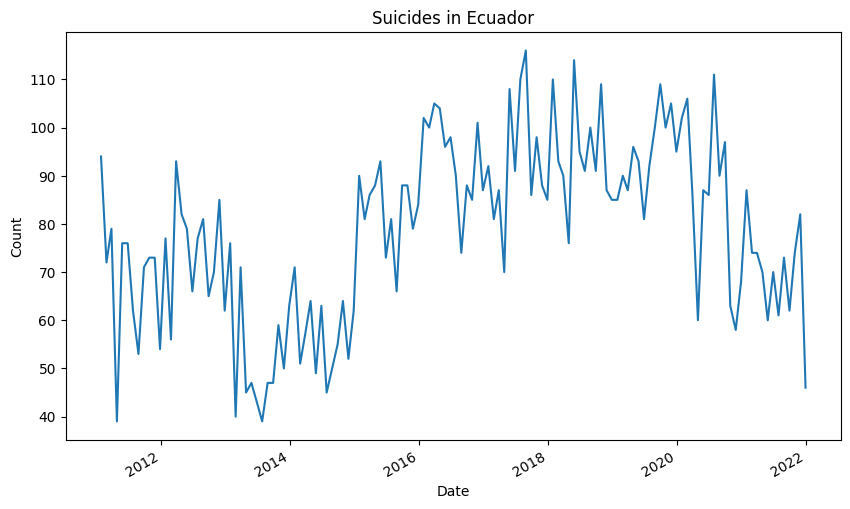

In [ ]:
df1 = df1.copy()
df1['date'] = pd.to_datetime(df1['date'])
df_grouped = df1[df1['date'].dt.year >= 2011].groupby('date').size()
df_grouped.plot(kind='line', figsize=(10, 6))
plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [ ]:
#Total suicides 2011-2022
df_grouped.sum() + 1170

11555

# Google Trends Data

In [ ]:
# Google Trends parameters
pytrends = TrendReq(hl='es-EC', tz=360, timeout=(10,25), proxies=['https://35.201.123.31:880',], retries=2, backoff_factor=0.1, requests_args={'verify':False}) #Ecuador
start_date = '2011-01-01'
end_date = '2021-12-31'

# Create a date range for reindexing
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

Proxy error. Changing IP
No more proxies available. Bye!


ProxyError: ignored

## General Category




In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_general1': ['suicidio', 'suicidio en Ecuador', 'intento de suicidio'],
    'keywords_general2': ['suicidarse', 'suicidarme'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_general = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_general = trends_cat_general.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_general.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_general = trends_cat_general.resample('M').sum()

# Set date index
trends_cat_general.index = trends_cat_general.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_general.head()

""
2011-01-31
2011-02-28
2011-03-31
2011-04-30
2011-05-31


In [ ]:
trends_cat_general.tail()

""
2021-08-31
2021-09-30
2021-10-31
2021-11-30
2021-12-31


In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_general.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_general.columns, colors):
    plt.plot(trends_cat_general.index, trends_cat_general[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - General Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Show the plot
plt.show()

### Consolidate Time Series - General Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_general == 0).sum() / len(trends_cat_general)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_general = trends_cat_general.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_general = pd.DataFrame(trend_cat_general, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_general.index, trend_cat_general['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - General Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Seeking Category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_seeking1': ['cómo suicidarse', 'como suicidarse','como suicidarme'],
    'keywords_seeking2': ['como matarme','como matarse','matarme','matarse'],
    'keywords_seeking3': ['formas de suicidio', 'formas de suicidarse', 'como suicidarme sin dolor', 'como suicidarse sin dolor'],
    'keywords_seeking4': ['suicidarse sin dolor', 'suicidio asistido', 'sobredosis', 'nota de suicidio'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_seeking = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_seeking = trends_cat_seeking.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_seeking.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_seeking = trends_cat_seeking.resample('M').sum()

# Set date index
trends_cat_seeking.index = trends_cat_seeking.index.to_period('M').to_timestamp('M')

TooManyRequestsError: ignored

In [ ]:
trends_cat_seeking.head()

In [ ]:
trends_cat_seeking.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_seeking.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_seeking.columns, colors):
    plt.plot(trends_cat_seeking.index, trends_cat_seeking[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Seeking Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Show the plot
plt.show()

### Consolidate Time Series - Seeking Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_seeking == 0).sum() / len(trends_cat_seeking)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_seeking = trends_cat_seeking.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_seeking = pd.DataFrame(trend_cat_seeking, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_seeking.index, trend_cat_seeking['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Seeking Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Prevention Category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_prevention1': ['ayuda psicologica','ayuda psicológica','psicologo','psicólogo','psicóloga'],
    'keywords_prevention2': ['sicóloga','psicoterapia','psicoterapia en línea','terapia psicologica','terapia psicológica'],
    'keywords_prevention3': ['atencion psicologica','atención psicológica','psiquiatra','siquiatra','prevencion del suicidio'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_prevention = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_prevention = trends_cat_prevention.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_prevention.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_prevention1 = trends_cat_prevention.resample('M').sum()

# Set date index
trends_cat_prevention1.index = trends_cat_prevention1.index.to_period('M').to_timestamp('M')

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_prevention4': ['prevención del suicidio','tecnicas de relajacion','técnicas de relajación','meditacion','meditación'],
    'keywords_prevention5': ['salud mental','salud mental ecuador','salud emocional','apoyo emocional'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_prevention = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_prevention = trends_cat_prevention.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_prevention.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_prevention2 = trends_cat_prevention.resample('M').sum()

# Set date index
trends_cat_prevention2.index = trends_cat_prevention2.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_prevention = trends_cat_prevention1.merge(trends_cat_prevention2, left_index=True, right_index=True, how='left')

In [ ]:
trends_cat_prevention.head()

In [ ]:
trends_cat_prevention.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_prevention.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_prevention.columns, colors):
    plt.plot(trends_cat_prevention.index, trends_cat_prevention[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Prevention Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')

# Show the plot
plt.show()

### Consolidate Time Series - Prevention Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_prevention == 0).sum() / len(trends_cat_prevention)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_prevention = trends_cat_prevention.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_prevention = pd.DataFrame(trend_cat_prevention, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_prevention.index, trend_cat_prevention['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Prevention Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Mood Category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'mood_keywords1': ['no quiero vivir', 'ya no quiero vivir', 'panico', 'pánico', 'ataques de panico'],
    'mood_keywords2': ['ataque de pánico', 'tengo miedo', 'fobia', 'sentimientos de tristeza', 'tristeza'],
    'mood_keywords3': ['estoy triste', 'cómo ser feliz', 'como ser feliz', 'paz interior', 'estoy enojado'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_mood = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_mood = trends_cat_mood.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_mood.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_mood1 = trends_cat_mood.resample('M').sum()

# Set date index
trends_cat_mood1.index = trends_cat_mood1.index.to_period('M').to_timestamp('M')

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'mood_keywords4': ['estoy solo', 'estoy sola', 'me siento sola', 'me siento solo', 'no tengo amigos'],
    'mood_keywords5': ['no tengo pareja', 'no tengo novio', 'no tengo novia', 'no tengo a nadie', 'mejorar la autoestima'],
    'mood_keywords6': ['mejorar el autoestima', 'amarse a uno mismo', 'estoy cansado', 'estoy cansada', 'cansancio'],
    'mood_keywords7': ['fatiga'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_mood = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_mood = trends_cat_mood.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_mood.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_mood2 = trends_cat_mood.resample('M').sum()

# Set date index
trends_cat_mood2.index = trends_cat_mood2.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_mood = trends_cat_mood1.merge(trends_cat_mood2, left_index=True, right_index=True, how='left')

In [ ]:
trends_cat_mood.head()

In [ ]:
trends_cat_mood.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_mood.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_mood.columns, colors):
    plt.plot(trends_cat_mood.index, trends_cat_mood[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Mood Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')

# Show the plot
plt.show()

### Consolidate Time Series - Mood Category



In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_mood == 0).sum() / len(trends_cat_mood)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_mood = trends_cat_mood.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_mood = pd.DataFrame(trend_cat_mood, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_mood.index, trend_cat_mood['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Mood Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Disorders category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'disorder_keywords1': ['síntomas de depresión', 'sintomas de depresion', 'tengo depresion', 'tengo depresión', 'depresión'],
    'disorder_keywords2': ['depresion', 'depresion ecuador', 'depresión ecuador', 'antidepresivo', 'ansiedad'],
    'disorder_keywords3': ['síntomas de ansiedad', 'calmar la ansiedad', 'tengo ansiedad', 'psicosis', 'sicosis'],
    'disorder_keywords4': ['alucinaciones', 'escuchar voces', 'bipolaridad', 'trastorno bipolar', 'TOC'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_disorder = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_disorder = trends_cat_disorder.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_disorder.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_disorder1 = trends_cat_disorder.resample('M').sum()

# Set date index
trends_cat_disorder1.index = trends_cat_disorder1.index.to_period('M').to_timestamp('M')

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'disorder_keywords5': ['síntomas de esquizofrenia', 'sintomas de esquizofrenia', 'esquizofrenia', 'estrés postraumático', 'estres postraumatico'],
    'disorder_keywords6': ['TEPT', 'síntomas de la anorexia', 'sintomas de la anorexia', 'anorexia', 'tratamiento anorexia'],
    'disorder_keywords7': ['no puedo dormir', 'no tengo sueño', 'insomnio', 'trastorno del sueño', 'pastillas para dormir'],
    'disorder_keywords8': ['tengo pesadillas']
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_disorder = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_disorder = trends_cat_disorder.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_disorder.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_disorder2 = trends_cat_disorder.resample('M').sum()

# Set date index
trends_cat_disorder2.index = trends_cat_disorder2.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_disorder = trends_cat_disorder1.merge(trends_cat_disorder2, left_index=True, right_index=True, how='left')

In [ ]:
trends_cat_disorder.head()

In [ ]:
trends_cat_disorder.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_disorder.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_disorder.columns, colors):
    plt.plot(trends_cat_disorder.index, trends_cat_disorder[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Disorder Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')

# Show the plot
plt.show()

### Consolidate Time Series - Disorder Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_disorder == 0).sum() / len(trends_cat_disorder)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_disorder = trends_cat_disorder.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_disorder = pd.DataFrame(trend_cat_disorder, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_disorder.index, trend_cat_disorder['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Disorder Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Stress category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'stress_keywords1': ['donde buscar trabajo', 'no tengo trabajo', 'trabajo en eeuu', 'trabajo en estados unidos', 'trabajo mexico'],
    'stress_keywords2': ['trabajo méxico', 'me despidieron', 'burnout', 'sobreexigencia laboral', 'presión en el trabajo'],
    'stress_keywords3': ['estrés laboral', 'ruptura', 'ruptura amorosa', 'divorcio', 'separación'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_stress = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_stress = trends_cat_stress.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_stress.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_stress1 = trends_cat_stress.resample('M').sum()

# Set date index
trends_cat_stress1.index = trends_cat_stress1.index.to_period('M').to_timestamp('M')

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'stress_keywords4': ['me divorcie', 'traicion', 'infidelidad', 'no tengo dinero', 'problemas económicos'],
    'stress_keywords5': ['problemas economicos', 'deudas']
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_stress = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_stress = trends_cat_stress.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_stress.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_stress2 = trends_cat_stress.resample('M').sum()

# Set date index
trends_cat_stress2.index = trends_cat_stress2.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_stress = trends_cat_stress1.merge(trends_cat_stress2, left_index=True, right_index=True, how='left')

In [ ]:
trends_cat_stress.head()

In [ ]:
trends_cat_stress.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_stress.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_stress.columns, colors):
    plt.plot(trends_cat_stress.index, trends_cat_stress[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Stress Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')

# Show the plot
plt.show()

### Consolidate Time Series - Disorder Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_stress == 0).sum() / len(trends_cat_stress)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_stress = trends_cat_stress.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_stress = pd.DataFrame(trend_cat_stress, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_stress.index, trend_cat_stress['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Stress Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Trauma Category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_trauma1': ['abuso sexual', 'violacion sexual','extorsión', 'extorsion'],
    'keywords_trauma2': ['amenazas', 'bullying','violencia familiar','violencia doméstica'],
    'keywords_trauma3': ['violencia domestica', 'maltrato familiar'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_trauma = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_trauma = trends_cat_trauma.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_trauma.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_trauma = trends_cat_trauma.resample('M').sum()

# Set date index
trends_cat_trauma.index = trends_cat_trauma.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_trauma.head()

In [ ]:
trends_cat_trauma.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_trauma.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_trauma.columns, colors):
    plt.plot(trends_cat_trauma.index, trends_cat_trauma[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Trauma Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Show the plot
plt.show()

### Consolidate Time Series - Seeking Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_trauma == 0).sum() / len(trends_cat_trauma)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_trauma = trends_cat_trauma.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_trauma = pd.DataFrame(trend_cat_trauma, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_trauma.index, trend_cat_trauma['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Trauma Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Minorities Category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_min1': ['homofobia', 'lesbofobia','transfobia'],
    'keywords_min2': ['racismo', 'discriminación racial','xenofobia','como migrar']
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_minorities = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_minorities = trends_cat_minorities.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_minorities.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_minorities = trends_cat_minorities.resample('M').sum()

# Set date index
trends_cat_minorities.index = trends_cat_minorities.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_minorities.head()

In [ ]:
trends_cat_minorities.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_minorities.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_minorities.columns, colors):
    plt.plot(trends_cat_minorities.index, trends_cat_minorities[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Minorities Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Show the plot
plt.show()

### Consolidate Time Series - Seeking Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_minorities == 0).sum() / len(trends_cat_minorities)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_minorities = trends_cat_minorities.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_minorities = pd.DataFrame(trend_cat_minorities, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_minorities.index, trend_cat_minorities['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Minorities Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

## Digital Violence Category

In [ ]:
# Define keywords lists
keyword_lists = {
    # General 5 terms
    'keywords_digital1': ['acoso en redes sociales', 'ciberacoso','ciberbullying'],
    'keywords_digital2': ['bullying cibernético', 'acoso en internet'],
    'keywords_digital3': ['xenofobia', 'como migrar'],
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_digital = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_digital = trends_cat_digital.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_digital.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the sum of daily values within each month
trends_cat_digital = trends_cat_digital.resample('M').sum()

# Set date index
trends_cat_digital.index = trends_cat_digital.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_digital.head()

In [ ]:
trends_cat_digital.tail()

In [ ]:
# Set the style of the matplotlib plot
sns.set(style='whitegrid')

# Set the size of the figure
plt.figure(figsize=(10, 4))

# Define a list of distinct colors for each column
colors = sns.color_palette('husl', n_colors=len(trends_cat_digital.columns))

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_digital.columns, colors):
    plt.plot(trends_cat_digital.index, trends_cat_digital[column], label=column, color=color, lw=1.5, linestyle=':')

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Digital Violence Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Monthly Popularity Index', fontsize=9)

# Add a legend to the plot outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Show the plot
plt.show()

### Consolidate Time Series - Seeking Category

In [ ]:
# Get the weights based on the % of missings
weights = (1 - (trends_cat_digital == 0).sum() / len(trends_cat_digital)).to_dict()
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# Apply weights and consolidate
trend_cat_digital = trends_cat_digital.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
trend_cat_digital = pd.DataFrame(trend_cat_digital, columns=['Consolidated_Trend'])

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 4))

# Plot the consolidated time series
plt.plot(trend_cat_digital.index, trend_cat_digital['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

# Adding title and labels
plt.title('Consolidated Trends - Digital Violence Category', fontsize=11)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

# Show the plot
plt.show()

# Prewhitening Time Series

## Get Residuals by SARIMA/ARIMA models

For the correlation analysis it is necessary to omit the autocorrelation and the seasonal effect of the series. To do this, we fit ARIMA and SARIMA models and use the residuals.

In [ ]:
# ARIMA - SARIMA fit functions

def fit_best_model(df, train_size=0.8, seasonal_period=12):
    # Extract the time series (assuming it's the first column)
    time_series = df.iloc[:, 0]

    # Split the data into train and test sets
    y_train, y_test = train_test_split(time_series, train_size=train_size)

    # Fit ARIMA model (non-seasonal)
    arima_model = pm.auto_arima(y_train, seasonal=False, trace=True,
                                error_action='ignore', suppress_warnings=True,
                                stepwise=True)

    # Fit SARIMA model (seasonal)
    sarima_model = pm.auto_arima(y_train, seasonal=True, m=seasonal_period,
                                 trace=True, error_action='ignore', suppress_warnings=True,
                                 stepwise=True)

    # Compare AIC and BIC
    print(f"\nARIMA AIC: {arima_model.aic()}, ARIMA BIC: {arima_model.bic()}")
    print(f"SARIMA AIC: {sarima_model.aic()}, SARIMA BIC: {sarima_model.bic()}")

    # Choose the model with the lower AIC/BIC
    best_model = sarima_model if sarima_model.aic() < arima_model.aic() else arima_model
    model_type = "SARIMA" if best_model is sarima_model else "ARIMA"
    print(f"Best Model: {model_type}")

    return best_model

## Suicide Residuals



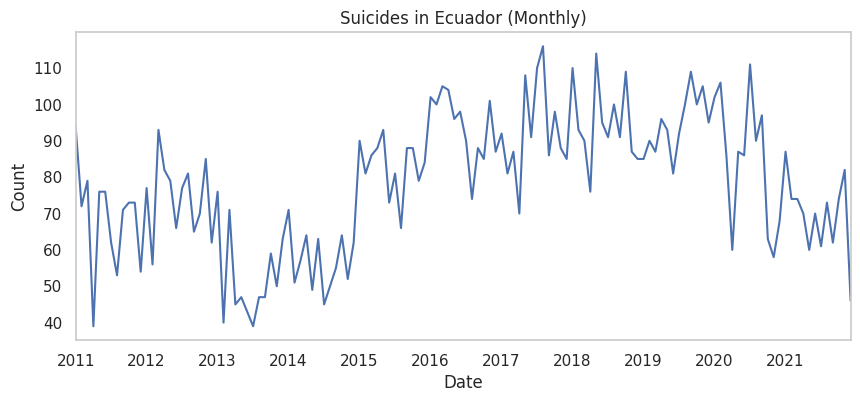

In [ ]:
df_monthly = df1.copy()
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_monthly = df_monthly[df_monthly['date'].dt.year >= 2011]
daily_counts = df_monthly.groupby('date').size()
monthly_counts = daily_counts.resample('M').sum()
monthly_counts.plot(kind='line', figsize=(10, 4))
plt.title('Suicides in Ecuador (Monthly)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Convert 'monthly_counts' Series to DataFrame
monthly_counts_df = monthly_counts.to_frame(name='Suicide_Counts')
monthly_counts_df.index = pd.to_datetime(monthly_counts_df.index)

In [ ]:
best_model_mortality = fit_best_model(monthly_counts_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=831.361, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=870.807, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=832.637, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=829.179, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=868.816, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=829.339, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=830.011, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=828.345, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=831.509, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=830.304, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=829.363, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=829.421, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=826.597, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=828.179, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=827.4

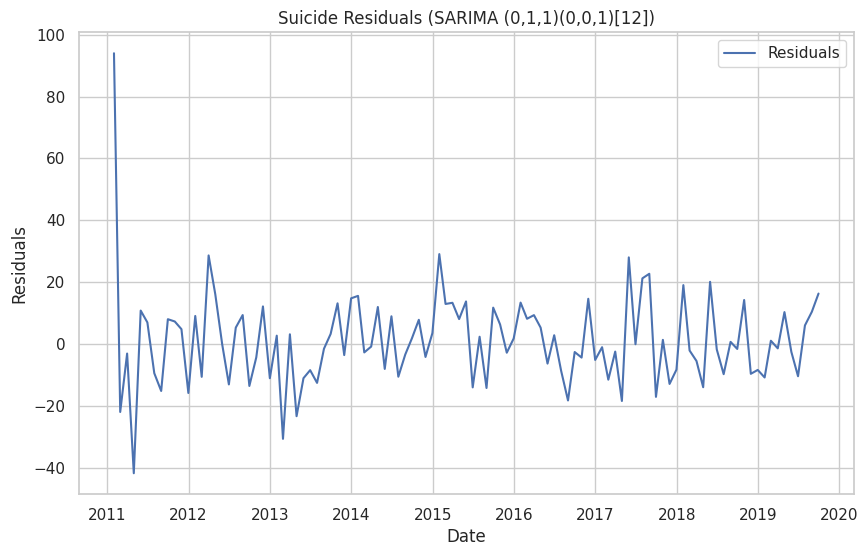

In [ ]:
# Extract residuals and create a DataFrame
residuals_mortality = pd.DataFrame(best_model_mortality.resid(), index=monthly_counts_df.index, columns=['Residuals Mortality'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_mortality, label='Residuals')
plt.title('Suicide Residuals (SARIMA (0,1,1)(0,0,1)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## General Trends Residuals

In [ ]:
best_model_general = fit_best_model(trend_cat_general)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=523.656, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=574.322, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=554.585, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=525.062, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=572.337, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=526.136, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=525.960, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=525.371, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=521.978, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=524.130, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=524.351, Time=0.43 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=523.922, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=526.123, Time=0.15 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=529.387, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=519.9

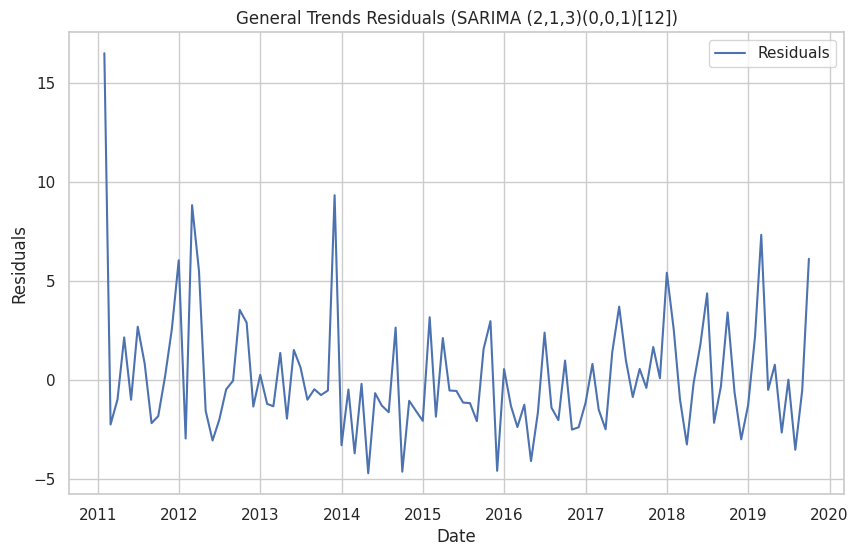

In [ ]:
# Extract residuals and create a DataFrame
residuals_general = pd.DataFrame(best_model_general.resid(), index=trend_cat_general.index, columns=['Residuals General Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_general, label='Residuals')
plt.title('General Trends Residuals (SARIMA (2,1,3)(0,0,1)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Seeking Trends Residuals

In [ ]:
best_model_seeking = fit_best_model(trend_cat_seeking)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=888.961, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=635.381, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=785.088, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=625.757, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=587.310, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=586.651, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=743.365, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.786 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=581.265, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=576.567, Time=0.03 sec
 ARIMA

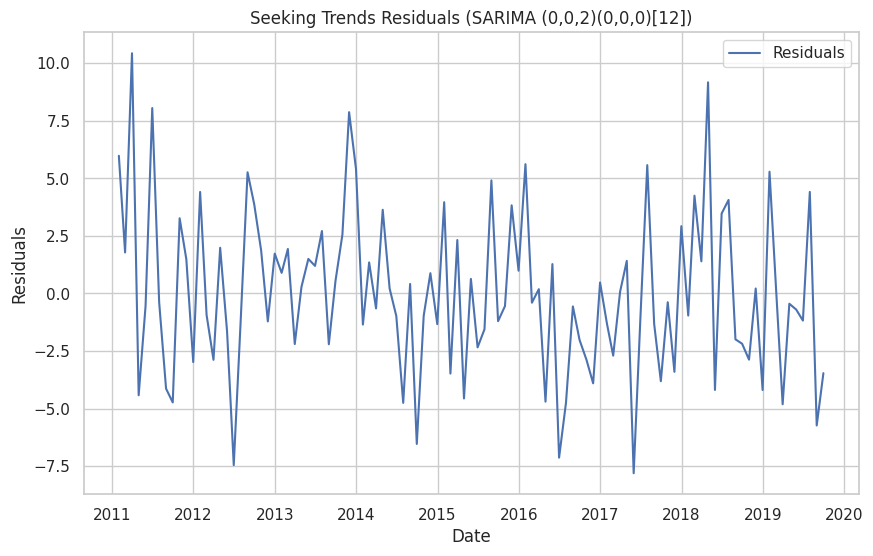

In [ ]:
# Extract residuals and create a DataFrame
residuals_seeking = pd.DataFrame(best_model_seeking.resid(), index=trend_cat_seeking.index, columns=['Residuals Seeking Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_seeking, label='Residuals')
plt.title('Seeking Trends Residuals (SARIMA (0,0,2)(0,0,0)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Prevention Trends Residuals

In [ ]:
best_model_prevention = fit_best_model(trend_cat_prevention)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=469.798, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=524.120, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=513.901, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=473.738, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=522.149, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=472.051, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=468.800, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=475.434, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=494.221, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=469.833, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=481.841, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=471.150, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=468.541, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=475.534, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=492.3

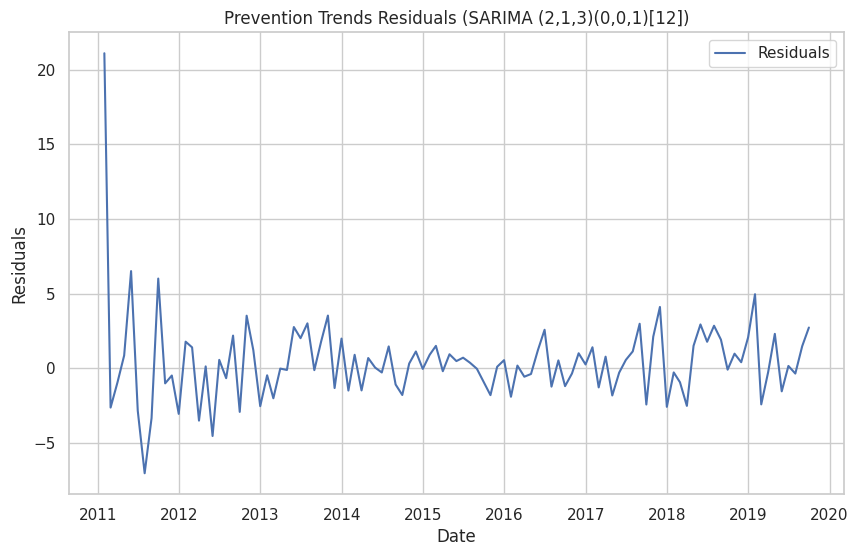

In [ ]:
# Extract residuals and create a DataFrame
residuals_prevention = pd.DataFrame(best_model_prevention.resid(), index=trend_cat_prevention.index, columns=['Residuals Prevention Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_prevention, label='Residuals')
plt.title('Prevention Trends Residuals (SARIMA (0,1,1)(1,0,1)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Mood Trends Residuals

In [ ]:
best_model_mood = fit_best_model(trend_cat_mood)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=501.145, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=475.797, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=462.476, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=499.163, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=463.337, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=463.663, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=460.500, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=461.432, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=461.728, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=473.804, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.490 seconds
Performing stepwise search to minimize aic
 ARI

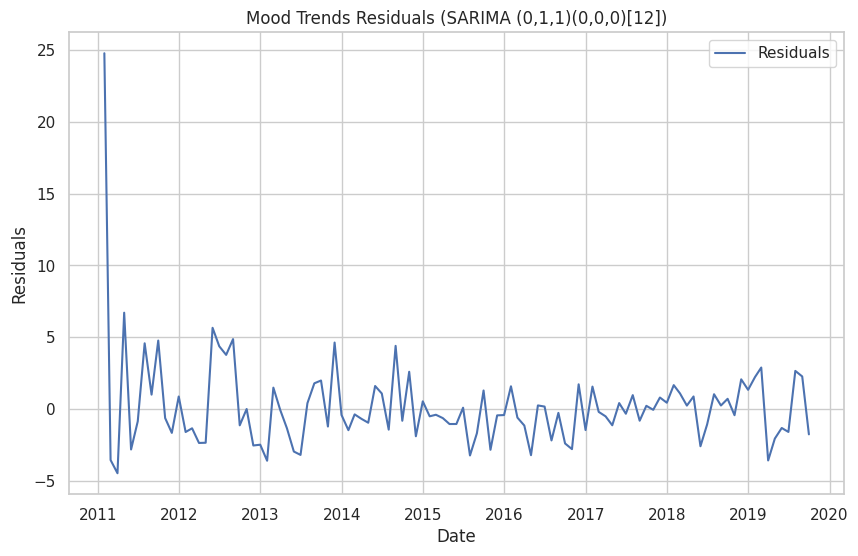

In [ ]:
# Extract residuals and create a DataFrame
residuals_mood = pd.DataFrame(best_model_mood.resid(), index=trend_cat_mood.index, columns=['Residuals Mood Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_mood, label='Residuals')
plt.title('Mood Trends Residuals (SARIMA (0,1,1)(0,0,0)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Disorders Trends Residuals

In [ ]:
best_model_disorder = fit_best_model(trend_cat_disorder)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=425.838, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=885.213, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=763.716, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=424.208, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=681.151, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=427.572, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=424.493, Time=0.40 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=631.656, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=425.911, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=427.615, Time=1.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=420.215, Time=1.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=433.638, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=423.836, Time=0.91 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=421.934, 

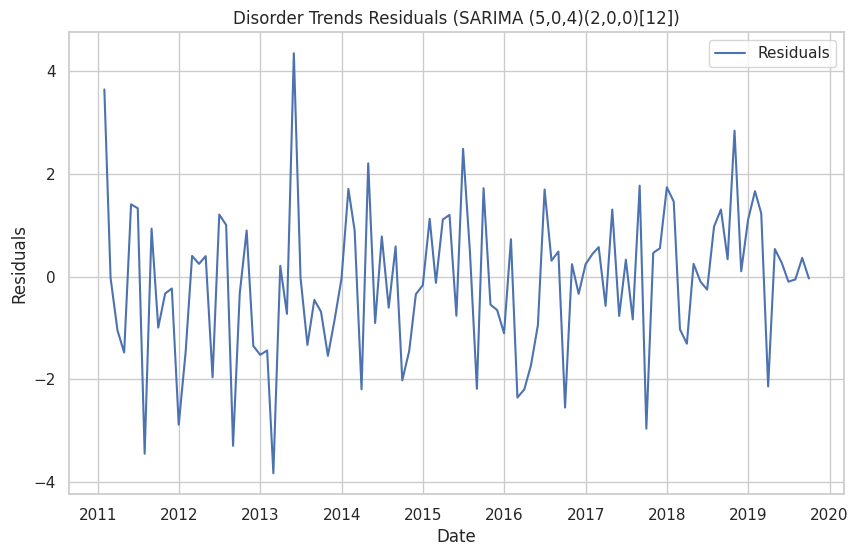

In [ ]:
# Extract residuals and create a DataFrame
residuals_disorder = pd.DataFrame(best_model_disorder.resid(), index=trend_cat_disorder.index, columns=['Residuals Disorder Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_disorder, label='Residuals')
plt.title('Disorder Trends Residuals (SARIMA (5,0,4)(2,0,0)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Stress Trends Residuals

In [ ]:
best_model_stress = fit_best_model(trend_cat_stress)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=465.456, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=509.023, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=488.505, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=460.562, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=507.101, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=462.366, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=462.309, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=458.595, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=460.403, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=460.349, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=486.558, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.160 seconds
Performing stepwise search to minimize aic


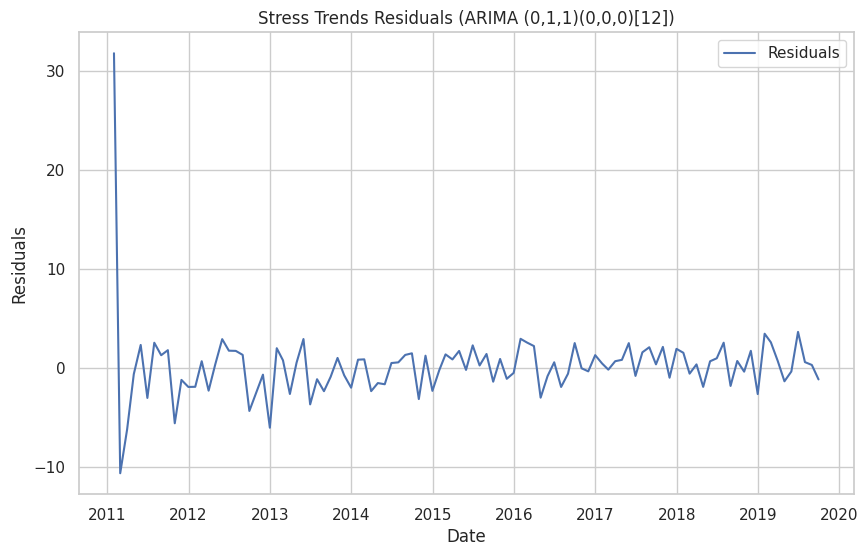

In [ ]:
# Extract residuals and create a DataFrame
residuals_stress = pd.DataFrame(best_model_stress.resid(), index=trend_cat_stress.index, columns=['Residuals Stress Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_stress, label='Residuals')
plt.title('Stress Trends Residuals (ARIMA (0,1,1)(0,0,0)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Trauma Trends Residuals

In [ ]:
best_model_trauma = fit_best_model(trend_cat_trauma)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=618.089, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=858.798, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=644.238, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=766.265, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=617.634, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=726.830, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=618.841, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=614.135, Time=0.53 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=695.895, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=619.313, Time=0.76 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=616.087, Time=0.52 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=690.426, Time=0.57 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=608.918, Time=0.65 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=607.015, 

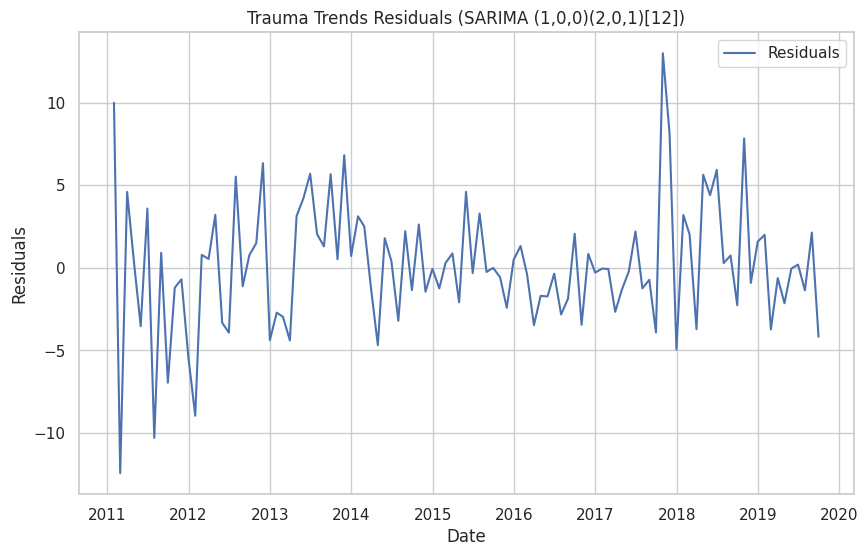

In [ ]:
# Extract residuals and create a DataFrame
residuals_trauma = pd.DataFrame(best_model_trauma.resid(), index=trend_cat_trauma.index, columns=['Residuals Trauma Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_trauma, label='Residuals')
plt.title('Trauma Trends Residuals (SARIMA (1,0,0)(2,0,1)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Minorities Trends Residuals

In [ ]:
best_model_minorities = fit_best_model(trend_cat_minorities)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=561.915, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=617.139, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=599.966, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=565.096, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=615.141, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=568.273, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=566.900, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=558.951, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=564.037, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=556.731, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=555.435, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=562.748, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=556.629, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=586.635, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=555.2

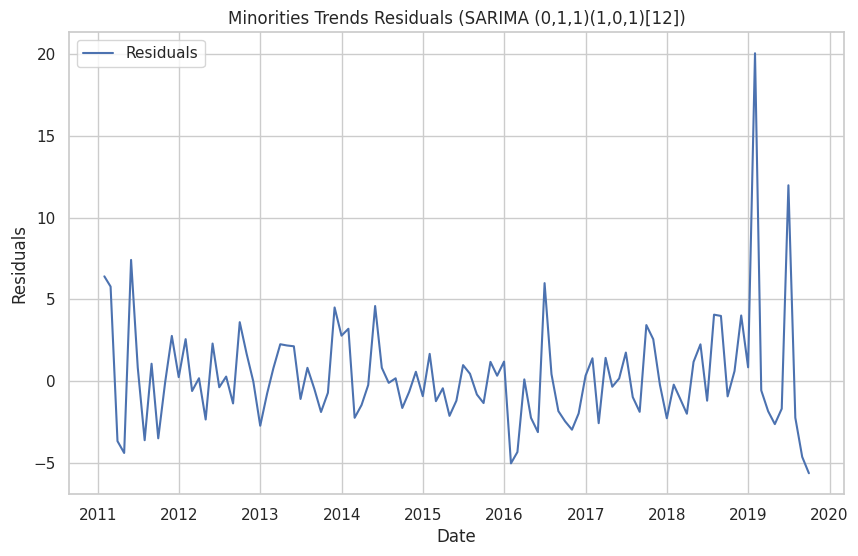

In [ ]:
# Extract residuals and create a DataFrame
residuals_minorities = pd.DataFrame(best_model_minorities.resid(), index=trend_cat_minorities.index, columns=['Residuals Minorities Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_minorities, label='Residuals')
plt.title('Minorities Trends Residuals (SARIMA (0,1,1)(1,0,1)[12])')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Digital Violence Trends Residuals

In [ ]:
best_model_digital = fit_best_model(trend_cat_digital)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=560.829, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=671.673, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=588.931, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=626.872, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=559.047, Time=0.42 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=612.061, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=559.115, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=561.024, Time=0.45 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=606.664, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=559.168, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=562.227, Time=0.68 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=554.889, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=554.927, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=553.552, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=553.1

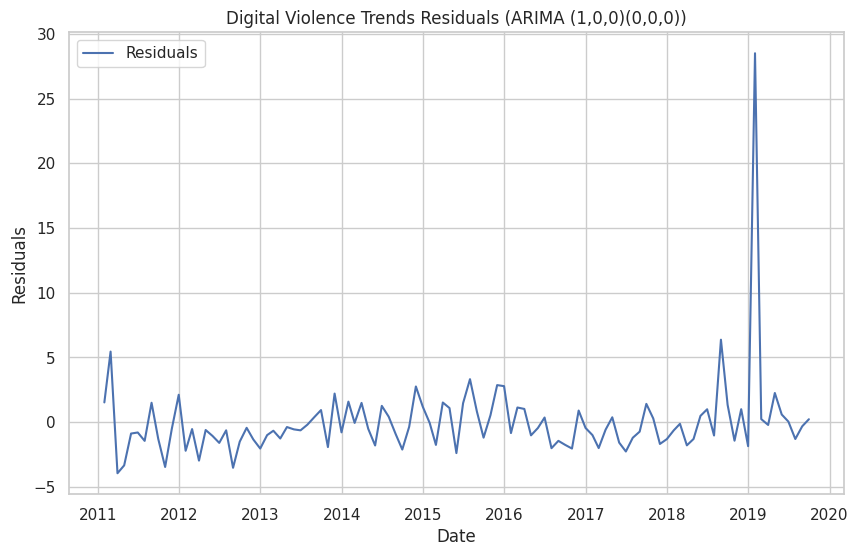

In [ ]:
# Extract residuals and create a DataFrame
residuals_digital = pd.DataFrame(best_model_digital.resid(), index=trend_cat_digital.index, columns=['Residuals Digital Trends'])

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_digital, label='Residuals')
plt.title('Digital Violence Trends Residuals (ARIMA (1,0,0)(0,0,0))')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Residuals Correlations and Cross Correlations

In [ ]:
# Function to determine significance level
def significance_level(value, se):
    if abs(value) > 2 * se:
        return "***"  # 99% confidence
    elif abs(value) > 1.96 * se:
        return "**"  # 95% confidence
    elif abs(value) > 1.645 * se:
        return "*"  # 90% confidence
    else:
        return ""

## General Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_general, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals General Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals General Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals General Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.341 ***
Lag 0: 0.341 ***
Lag 1: -0.069 
Lag 2: -0.116 
Lag 3: -0.070 
Lag 4: -0.023 
Lag 5: 0.174 **
Lag 6: -0.010 
Lag 7: -0.106 
Lag 8: -0.103 
Lag 9: -0.050 
Lag 10: -0.102 
Lag 11: 0.078 
Lag 12: -0.039 


## Seeking Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_seeking, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Seeking Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Seeking Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Seeking Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.075 
Lag 0: 0.075 
Lag 1: 0.066 
Lag 2: 0.132 
Lag 3: -0.170 *
Lag 4: -0.057 
Lag 5: 0.097 
Lag 6: -0.027 
Lag 7: -0.102 
Lag 8: -0.049 
Lag 9: 0.010 
Lag 10: 0.021 
Lag 11: 0.069 
Lag 12: 0.001 


## Prevention Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_prevention, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Prevention Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Prevention Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Prevention Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.513 ***
Lag 0: 0.513 ***
Lag 1: -0.192 ***
Lag 2: -0.081 
Lag 3: 0.114 
Lag 4: 0.164 *
Lag 5: -0.118 
Lag 6: -0.173 **
Lag 7: -0.119 
Lag 8: 0.078 
Lag 9: -0.053 
Lag 10: -0.066 
Lag 11: 0.015 
Lag 12: 0.010 


## Mood Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_mood, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Mood Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Mood Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Mood Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.360 ***
Lag 0: 0.360 ***
Lag 1: -0.054 
Lag 2: -0.034 
Lag 3: 0.110 
Lag 4: 0.021 
Lag 5: -0.143 
Lag 6: 0.048 
Lag 7: -0.040 
Lag 8: 0.146 *
Lag 9: -0.051 
Lag 10: -0.073 
Lag 11: 0.035 
Lag 12: -0.007 


## Disorders Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_disorder, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Disorder Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Disorder Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Disorder Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.279 ***
Lag 0: 0.279 ***
Lag 1: -0.138 
Lag 2: -0.035 
Lag 3: 0.025 
Lag 4: 0.064 
Lag 5: 0.193 ***
Lag 6: -0.112 
Lag 7: -0.006 
Lag 8: -0.003 
Lag 9: 0.017 
Lag 10: -0.149 *
Lag 11: -0.268 ***
Lag 12: -0.079 


## Stress Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_stress, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Stress Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Stress Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Stress Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.533 ***
Lag 0: 0.533 ***
Lag 1: -0.154 *
Lag 2: -0.030 
Lag 3: 0.009 
Lag 4: 0.062 
Lag 5: -0.041 
Lag 6: 0.060 
Lag 7: -0.032 
Lag 8: 0.069 
Lag 9: -0.079 
Lag 10: 0.023 
Lag 11: -0.036 
Lag 12: -0.009 


## Trauma Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_trauma, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Trauma Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Trauma Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Trauma Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: 0.243 ***
Lag 0: 0.243 ***
Lag 1: -0.203 ***
Lag 2: -0.072 
Lag 3: 0.149 *
Lag 4: -0.123 
Lag 5: 0.199 ***
Lag 6: -0.172 **
Lag 7: -0.119 
Lag 8: -0.081 
Lag 9: -0.018 
Lag 10: 0.011 
Lag 11: -0.074 
Lag 12: -0.161 *


## Minorities Category Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_minorities, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Minorities Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Minorities Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Minorities Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: -0.012 
Lag 0: -0.012 
Lag 1: -0.022 
Lag 2: 0.003 
Lag 3: -0.028 
Lag 4: 0.097 
Lag 5: 0.001 
Lag 6: -0.091 
Lag 7: -0.058 
Lag 8: 0.017 
Lag 9: -0.133 
Lag 10: -0.029 
Lag 11: -0.103 
Lag 12: 0.183 ***


## Digital Violence Correlations

In [ ]:
# Align the datasets
aligned_df = pd.merge(residuals_digital, residuals_mortality, left_index=True, right_index=True, how='inner')
aligned_df['Residuals Digital Trends'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
aligned_df['Residuals Mortality'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Calculate Pearson Correlation and P-value
pearson_corr, pearson_p_value = pearsonr(aligned_df['Residuals Digital Trends'], aligned_df['Residuals Mortality'])

# Print Correlations with Significance
print(f"Pearson Correlation: {pearson_corr:.3f} {significance_level(pearson_corr, pearson_p_value)}")

# Cross-Correlation Analysis up to lag 12
ccf = sm.tsa.stattools.ccf(aligned_df['Residuals Digital Trends'], aligned_df['Residuals Mortality'], adjusted=True)[:13]

# Significance Level for Cross-Correlation
se = 1 / np.sqrt(len(aligned_df))

# Print Cross-Correlation for each lag with significance
for lag, corr in enumerate(ccf):
    print(f"Lag {lag}: {corr:.3f} {significance_level(corr, se)}")

Pearson Correlation: -0.059 
Lag 0: -0.059 
Lag 1: 0.097 
Lag 2: -0.052 
Lag 3: 0.091 
Lag 4: -0.106 
Lag 5: -0.025 
Lag 6: -0.032 
Lag 7: 0.022 
Lag 8: 0.068 
Lag 9: -0.176 ***
Lag 10: 0.008 
Lag 11: 0.026 
Lag 12: 0.110 


In [ ]:
df1.groupby('age_range').size().sort_values(ascending=False)

age_range
Adults (25-34)                2859
Teens (15-19)                 2116
Young adults (20-24)          2093
Middle-aged adults (35-44)    1687
Older adults (45-54)          1246
Seniors (55-64)                990
Pre-teens (10-14)              835
Retirement age (65-74)         605
Elderly (75-84)                325
Very elderly (+85)             106
Children (5-9)                  19
Infants and toddlers (0-4)       0
dtype: int64

# Sensitive analysis

This part seeks to understand the sensitivity of time series correlation analysis across specific groups. For this purpose, we will use gender, age ranges, and province.

## Gender

In [ ]:
df_gender = df1.copy()
df_gender['date'] = pd.to_datetime(df_gender['date'])
df_gender = df_gender[df_gender['date'].dt.year >= 2011]
df_gender = df_gender.groupby(['date', 'gender']).size().unstack(fill_value=0)
df_gender = df_gender.resample('M').sum()
df_gender.plot(kind='line', figsize=(10, 4))
plt.title('Suicides in Ecuador by gender (Monthly)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Convert 'monthly_counts' Series to DataFrame
#df_gender = df_gender.to_frame(name='Suicide_Counts')
#df_gender.index = pd.to_datetime(monthly_counts_df.index)

NameError: ignored

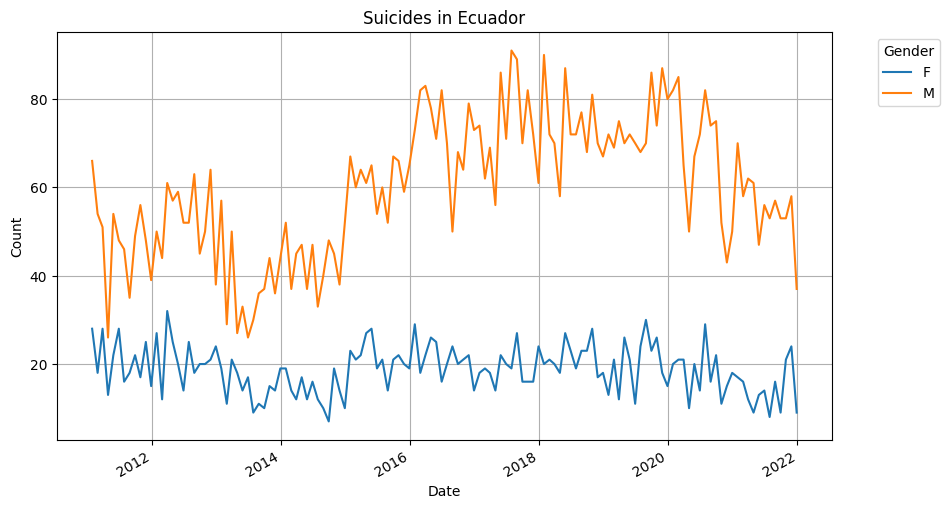

In [ ]:
# Group the data by date and description
df_grouped = df1[df1['date'].dt.year >= 2011].groupby(['date', 'gender']).size().unstack(fill_value=0)

# Plot a line for each description
df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

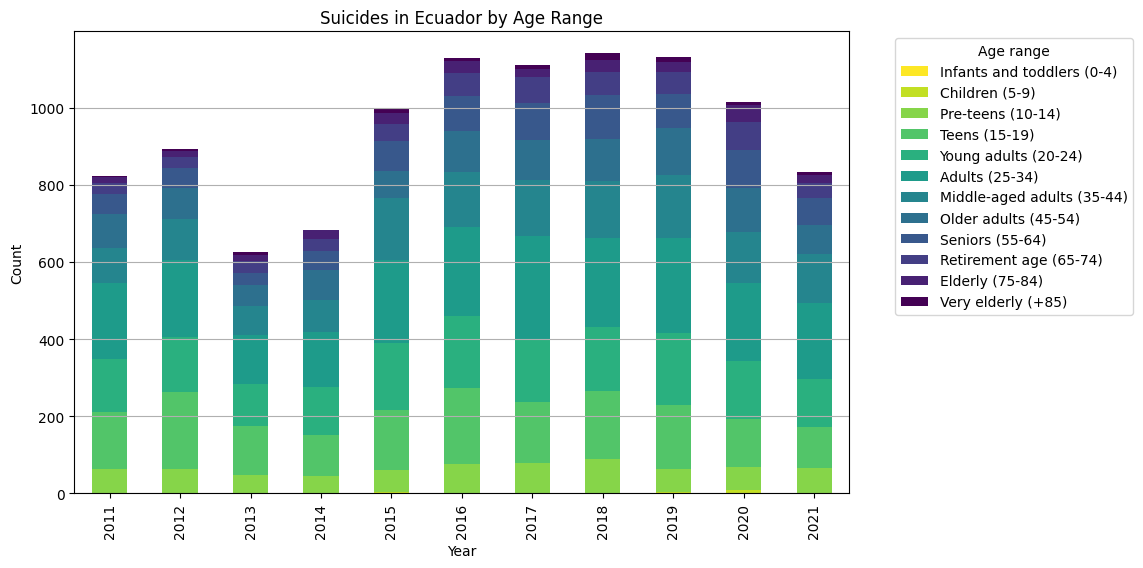

In [ ]:
# Group the data by year and age_range to get the count for each combination
df_grouped = df1[df1['date'].dt.year >= 2011].groupby([df1['date'].dt.year, 'age_range']).size().unstack(fill_value=0)

# Plot a stacked bar plot with years on the X-axis and counts on the Y-axis
df_grouped.plot(kind='bar', stacked=True, figsize=(10,6), cmap='viridis_r')

plt.title('Suicides in Ecuador by Age Range')
plt.xlabel('Year')
plt.ylabel('Count')  # Cambia el título del eje Y a "Count"
plt.legend(title='Age range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


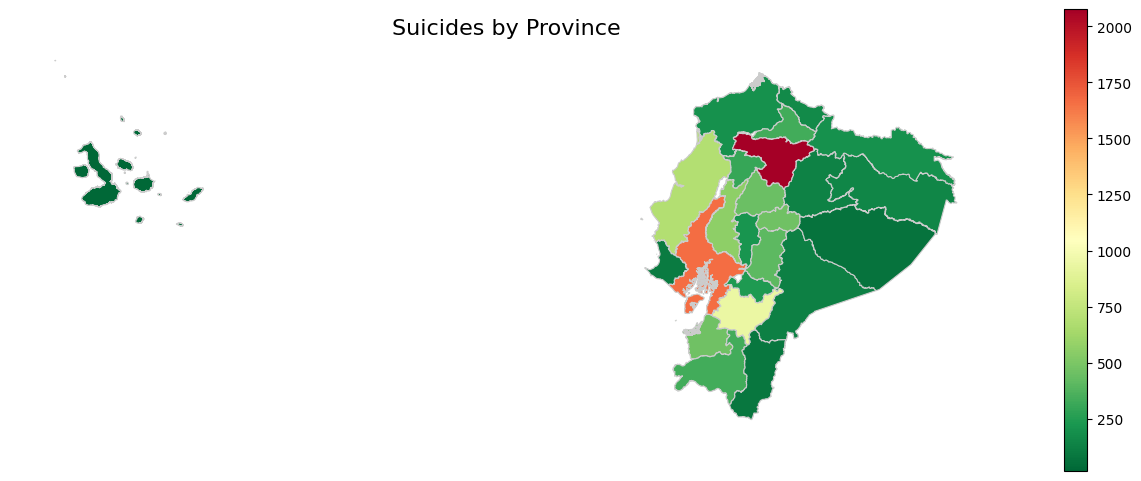

In [ ]:
# Group by province and calculate the total number of cases
province_counts = df1[df1['date'].dt.year >= 2011].groupby(['province', 'geometry']).size().reset_index(name='count')

# Create a GeoDataFrame with the province geometries and case counts
province_count = gpd.GeoDataFrame(province_counts, geometry='geometry')

# Create a larger figure
fig, ax = plt.subplots(1, 1, figsize=(16, 10))  # Adjust the figure size as needed

# Plot the map with a smaller color legend
province_count.plot(
    column='count',
    cmap='RdYlGn_r',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.6}  # Adjust the 'shrink' parameter to control legend size
)

# Set plot title and axis labels
ax.set_title('Suicides by Province', fontsize=16)
ax.set_axis_off()
plt.show()

In [ ]:
province_count

,province,geometry,count
0,Azuay,"POLYGON ((-78.56954 -2.55865, -78.56920 -2.558...",940
1,Bolívar,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",215
2,Carchi,"POLYGON ((-78.49647 1.19776, -78.49573 1.19763...",166
3,Cañar,"POLYGON ((-78.56954 -2.55865, -78.57007 -2.559...",241
4,Chimborazo,"POLYGON ((-78.35800 -1.52162, -78.35800 -1.521...",411
5,Cotopaxi,"POLYGON ((-78.42185 -0.71691, -78.42185 -0.716...",444
6,El Oro,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ...",461
7,Esmeraldas,"MULTIPOLYGON (((-79.90438 0.27876, -79.90431 0...",201
8,Galápagos,"MULTIPOLYGON (((-89.66637 -1.34547, -89.66625 ...",17
9,Guayas,"MULTIPOLYGON (((-80.16401 -3.01416, -80.16472 ...",1660


Pearson Correlation:  -0.403056572112661
P-value:  1.6547504685507007e-06


<ipython-input-38-9a76f0cdfd29>:17: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  ccf = sm.tsa.stattools.ccf(aligned_df['standardized_trend'], aligned_df['standardized_suicide_counts'], unbiased=True)


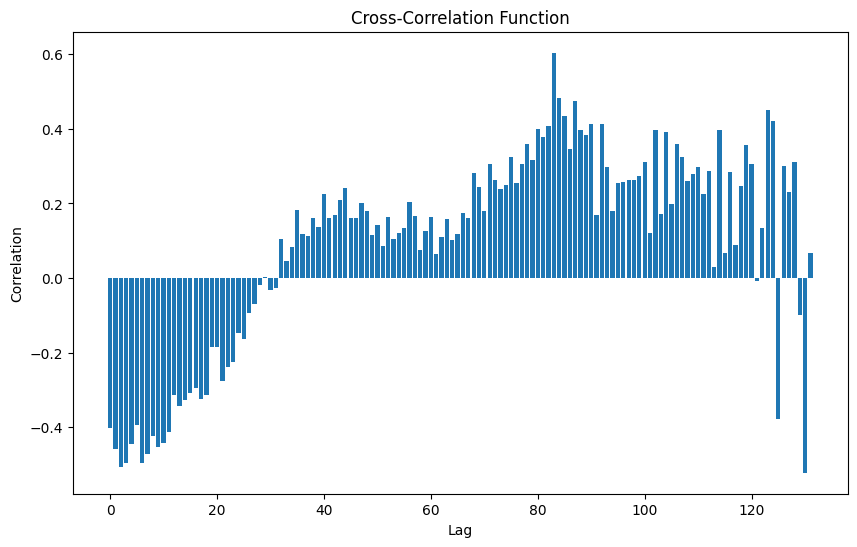

In [ ]:
# Convert 'monthly_counts' Series to DataFrame
monthly_counts_df = monthly_counts.to_frame(name='Suicide_Counts')

# Align the datasets
aligned_df = pd.merge(trend_cat_general, monthly_counts_df, left_index=True, right_index=True, how='inner')

# Calculate Pearson Correlation and P-value
correlation, p_value = pearsonr(aligned_df['Consolidated_Trend'], aligned_df['Suicide_Counts'])
print("Pearson Correlation: ", correlation)
print("P-value: ", p_value)

# Optionally standardize the data for cross-correlation analysis
aligned_df['standardized_trend'] = (aligned_df['Consolidated_Trend'] - aligned_df['Consolidated_Trend'].mean()) / aligned_df['Consolidated_Trend'].std()
aligned_df['standardized_suicide_counts'] = (aligned_df['Suicide_Counts'] - aligned_df['Suicide_Counts'].mean()) / aligned_df['Suicide_Counts'].std()

# Cross-Correlation Analysis
ccf = sm.tsa.stattools.ccf(aligned_df['standardized_trend'], aligned_df['standardized_suicide_counts'], unbiased=True)

# Plot the Cross-Correlation Function
plt.figure(figsize=(10, 6))
lags = range(len(ccf))
plt.bar(lags, ccf)
plt.title('Cross-Correlation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()


In [ ]:
# Define keywords lists
keyword_lists = {
      # Seeking 35 terms
      'keywords_seeking1': ['cómo suicidarse', 'como suicidarse', 'como suicidarme', 'cómo suicidarme'],
      'keywords_seeking2': ['quiero matarme', 'metodos de suicidio', 'método de suicidio', 'formas de suicidio'],
      'keywords_seeking3': ['formas de matarse', 'veneno para suicidio', 'venenos para suicidarme', 'suicidio por envenenamiento']
}

# Initialize an empty DataFrame for the consolidated data
trends_cat_seeking1 = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{subset_name}_{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_seeking1 = trends_cat_seeking1.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_seeking1.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the mean of daily values within each month
trends_cat_seeking1 = trends_cat_seeking1.resample('M').sum()

# The index of the resampled DataFrame is the last day of each month, to change it to the first day
trends_cat_seeking1.index = trends_cat_seeking1.index.to_period('M').to_timestamp('M')

In [ ]:
trends_cat_seeking1

,keywords_seeking1_cómo suicidarse,keywords_seeking1_como suicidarse,keywords_seeking1_como suicidarme,keywords_seeking1_cómo suicidarme,keywords_seeking2_quiero matarme,keywords_seeking2_metodos de suicidio,keywords_seeking2_método de suicidio,keywords_seeking2_formas de suicidio
2011-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
2011-02-28,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0
2011-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-05-31,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


In [ ]:
# Define keywords lists
keyword_lists = {
      # Seeking 35 terms
       'keywords_seeking4': ['sobredosis', 'sobredosis para sucidarme', 'suicidio sin dolor', 'suicidio asistido'],
       'keywords_seeking5': ['arma suicida', 'cómo cortarse las venas', 'dosis mortal', 'cómo dispararme'],
       'keywords_seeking6': ['suicidio efectivo', 'carta suicida', 'nota de suicidio', 'carta de suicidio']
       }

# Initialize an empty DataFrame for the consolidated data
trends_cat_seeking2 = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{subset_name}_{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_seeking2 = trends_cat_seeking2.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_seeking2.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the mean of daily values within each month
trends_cat_seeking2 = trends_cat_seeking2.resample('M').sum()

# The index of the resampled DataFrame is the last day of each month, to change it to the first day
trends_cat_seeking2.index = trends_cat_seeking2.index.to_period('M').to_timestamp('M')

In [ ]:
# Define keywords lists
keyword_lists = {
      # Seeking 35 terms
        'keywords_seeking7': ['foro suicida', 'saltar para matarse', 'salto suicida', 'lugares para saltar a morir'],
        'keywords_seeking8': ['salto al vacio lugares', 'lugares para suicidarse', 'como ahorcarme', 'como colgarme'],
        'keywords_seeking9': ['nudo para suicidarse', 'soga para ahorcarse', 'cómo asfixiarse']
       }

# Initialize an empty DataFrame for the consolidated data
trends_cat_seeking3 = pd.DataFrame(index=date_range)

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()
    if not data.empty:
        # Rename the columns to include the set name
        data.columns = [f'{subset_name}_{keyword}' for keyword in data.columns[:-1]] + [data.columns[-1]]
        # Remove the "isPartial" column
        data = data.drop('isPartial', axis=1, errors='ignore')
        # Merge the current data with the consolidated dataframe
        trends_cat_seeking2 = trends_cat_seeking2.merge(data, left_index=True, right_index=True, how='left')

# Replace NaN values with 0 to handle days with missing data
trends_cat_seeking3.fillna(0, inplace=True)

# Resample the data to monthly frequency by taking the mean of daily values within each month
trends_cat_seeking3 = trends_cat_seeking2.resample('M').sum()

# The index of the resampled DataFrame is the last day of each month, to change it to the first day
trends_cat_seeking3.index = trends_cat_seeking2.index.to_period('M').to_timestamp('M')

In [ ]:
# Merge the first two dataframes on their index
trends_cat_seeking = pd.merge(trends_cat_seeking1, trends_cat_seeking2, left_index=True, right_index=True, how='outer')
# Merge the resulting dataframe with the third one on their index
trends_cat_seeking = pd.merge(trends_cat_seeking, trends_cat_seeking3, left_index=True, right_index=True, how='outer')

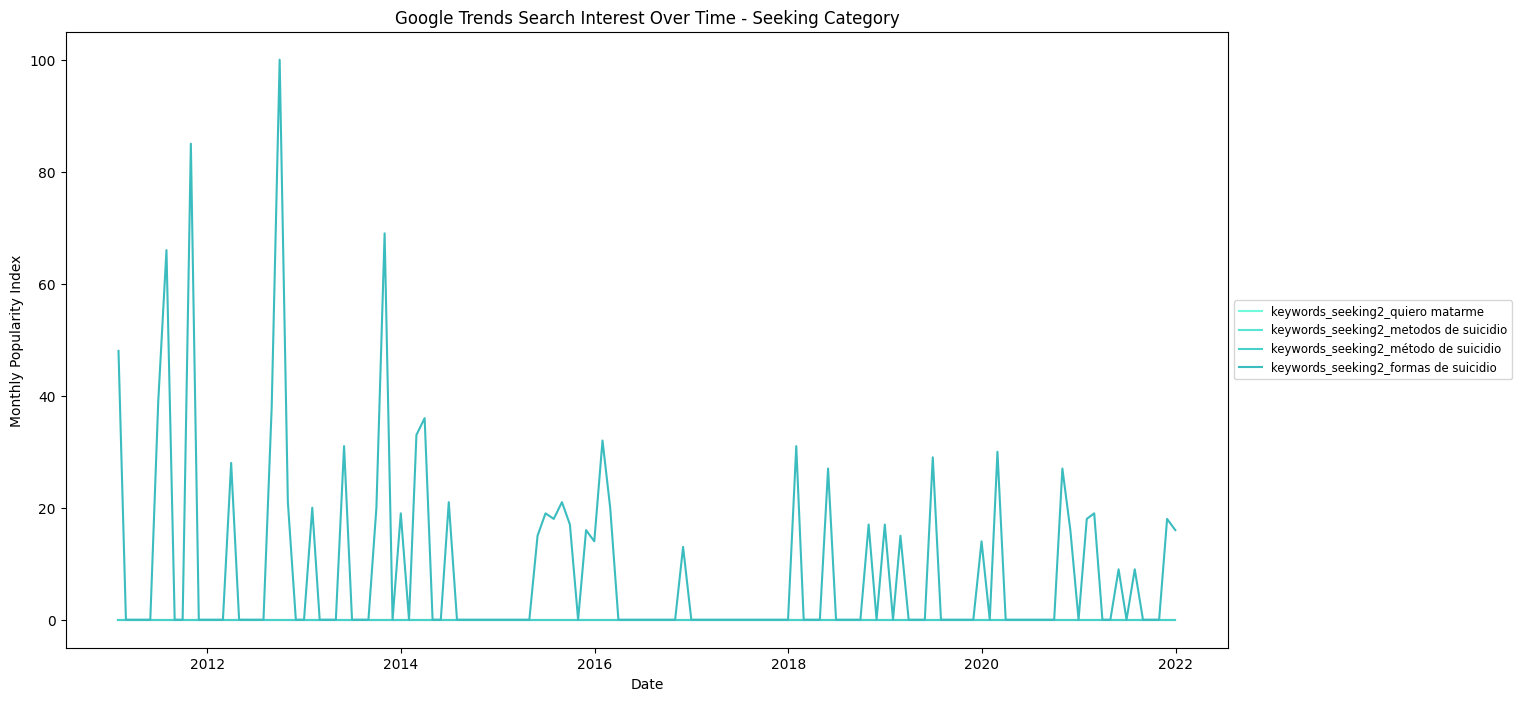

In [ ]:
# Use the default Matplotlib style
plt.style.use('default')

# Set the size of the figure
plt.figure(figsize=(15, 8))

# Define a list of colors to use in the plot
colors = ['#6efadb','#59e5d3','#48d0c9','#3bbcbe','#34a7b0','#3093a1','#2f7f91','#2f6c7f','#2d5a6c','#2a4858']

# Plot each column in the DataFrame using the colors list
for (column, color) in zip(trends_cat_seeking.columns, colors):
    plt.plot(trends_cat_seeking.index, trends_cat_seeking[column], label=column, color=color)

# Adding title and labels
plt.title('Google Trends Search Interest Over Time - Seeking Category')
plt.xlabel('Date')
plt.ylabel('Monthly Popularity Index')

# Add a legend to the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Show the plot
plt.show()

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      # Seeking 35 terms
      'keywords_seeking1': ['cómo suicidarse', 'como suicidarse', 'como suicidarme', 'cómo suicidarme'],
      'keywords_seeking2': ['quiero matarme', 'metodos de suicidio', 'método de suicidio', 'formas de suicidio'],
      'keywords_seeking3': ['formas de matarse', 'veneno para suicidio', 'venenos para suicidarme', 'suicidio por envenenamiento'],
      'keywords_seeking4': ['sobredosis', 'sobredosis para sucidarme', 'suicidio sin dolor', 'suicidio asistido'],
      'keywords_seeking5': ['arma suicida', 'cómo cortarse las venas', 'dosis mortal', 'cómo dispararme'],
      'keywords_seeking6': ['suicidio efectivo', 'carta suicida', 'nota de suicidio', 'carta de suicidio'],
      'keywords_seeking7': ['foro suicida', 'saltar para matarse', 'salto suicida', 'lugares para saltar a morir'],
      'keywords_seeking8': ['salto al vacio lugares', 'lugares para suicidarse', 'como ahoracarme', 'como colgarme'],
      'keywords_seeking9': ['nudo para suicidarse', 'soga para ahorcarse', 'cómo asfixiarse'],
      }

pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      # Prevention 47 terms
      'keywords_prevention1': ['psiquiatra', 'psiquiatra telefono', 'siquiatra', 'ayuda psicologica'],
      'keywords_prevention2': ['psicólogo', 'psicologo', 'psicologo telefono', 'psicólogo telefono'],
      'keywords_prevention3': ['sicologo', 'sicólogo', 'psicoterapia', 'terapia psicologica'],
      'keywords_prevention4': ['necesito terapia', 'sicoterapia', 'terapia sicologica', 'terapia sicológica'],
      'keywords_prevention5': ['atencion psicologica gratis', 'atencion psicologica online', 'emergencia psicologica', 'prevención del suicidio'],
      'keywords_prevention6': ['prevencion del suicidio', 'signos de advertencia del suicidio', 'como ayudar a alguien suicida', 'ayuda suicida'],
      'keywords_prevention7': ['meditación', 'terapia para el suicidio', 'tecnicas de relajacion', 'reducción del estrés'],
      'keywords_prevention8': ['como reducir el estres', 'salud mental', 'como mejorar mi salud mi salud emocional'],
      'keywords_prevention9': ['como mejorar mi salud mental', 'recursos para la salud mental', 'centros de salud mental Ecuador', 'clínica para suicidas'],
      'keywords_prevention10': ['charlas sobre salud mental', 'grupos de apoyo para la depresión', 'apoyo emocional', 'grupo de apoyo de suicidios'],
      'keywords_prevention11': ['consuelo suicida', 'que decir a una persona que quiere suicidarse', 'línea de ayuda para el suicidio', 'linea de ayuda para el suicidio'],
      'keywords_prevention12': ['línea de crisis', 'linea de crisis', 'crisis suicidio telefono', 'chat suicida'],
      }

pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      # Mood 34 terms
      'keywords_mood1': ['panico', 'ataques de panico', 'tengo panico', 'fobia', 'tengo miedo'],
      'keywords_mood2': ['sentimientos de tristeza', 'cómo superar la tristeza', 'tristeza crónica', 'estoy triste'],
      'keywords_mood3': ['cómo ser más feliz', 'paz interior', 'como encontrar la calma', 'cómo controlar el enojo'],
      'keywords_mood4': ['estoy enojado', 'terapia de la ira', 'tengo ira'],
      'keywords_mood5': ['estoy solo', 'cómo lidiar con la soledad', 'soledad en la vejez', 'me siento solo'],
      'keywords_mood6': ['no tengo amigos', 'no tengo a nadie', 'cómo saber si he perdido la autoestima'],
      'keywords_mood7': ['tengo baja autoestima', 'cómo recuperar el autoestima', 'mejorar el autoestima', 'no tengo autoestima'],
      }
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      # Disorders 47 terms
      'keywords_disorders1': ['síntomas de depresión', 'tengo depresión', 'depresion', 'depresión'],
      'keywords_disorders2': ['tratamiento para la depresión', 'medicamentos para la depresión en Ecuador'],
      'keywords_disorders3': ['cómo saber si tengo depresión', 'efectos secundarios de los antidepresivos'],
      'keywords_disorders4': ['antidepresivos', 'síntomas de ansiedad', 'cómo calmar la ansiedad'],
      'keywords_disorders5': ['tengo ansiedad', 'ansiedad', 'psicósis', 'psicosis'],
      'keywords_disorders6': ['alucinaciones', 'escucho voces', 'sicosis', 'síntomas del trastorno bipolar'],
      'keywords_disorders7': ['tratamiento del trastorno bipolar', 'medicamentos para el trastorno bipolar'],
      'keywords_disorders8': ['psiquiatras especializados en trastorno bipolar', 'soy bipolar', 'bipolaridad'],
      'keywords_disorders9': ['síntomas del trastorno obsesivo compulsivo', 'tratamiento para el TOC en Ecuador'],
      'keywords_disorders10': ['terapia para el TOC', 'síntomas de esquizofrenia', 'tratamiento para la esquizofrenia'],
      'keywords_disorders11': ['psiquiatras especializados en esquizofrenia', 'tengo esquizofrenia', 'soy esquizofrenico'],
      'keywords_disorders12': ['síntomas estrés postraumático', 'tratamiento para el TEPT', 'estres postraumatico'],
      'keywords_disorders13': ['tengo estrés postraumatico', 'síntomas de la anorexia', 'tengo anorexia'],
      'keywords_disorders14': ['tratamiento para la anorexia', 'tratamiento para la bulimia', 'tengo bulimia'],
      'keywords_disorders15': ['no puedo dormir', 'trastorno del sueño'],
      'keywords_disorders16': ['no tengo sueño', 'insomnio', 'pastillas para dormir'],
      }
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      #Stress 27 terms
      'keywords_stress1': ['donde buscar trabajo', 'trabajo eeuu', 'trabajo mexico'],
      'keywords_stress2': ['estoy desempleado', 'me despidieron', 'no tengo trabajo'],
      'keywords_stress3': ['burnout', 'sobreexigencia laboral', 'presión en el trabajo'],
      'keywords_stress4': ['estrés laboral', 'presión laboral', 'abuso laboral'],
      'keywords_stress5': ['ruptura', 'ruptura amorosa', 'divorcio', 'separación'],
      'keywords_stress6': ['como saber si me traicionan', 'me traicionaron', 'me traicionó', 'infidelidad'],
      'keywords_stress7': ['cansancio', 'estoy agotado', 'fatiga'],
      'keywords_stress8': ['no tengo dinero', 'problemas económicos', 'deudas', 'no puedo pagar mis deudas'],
      }
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      #Traumas 15 terms
      'keywords_traumas1': ['fui abusada', 'abuso sexual', 'fui abusada sexualmente', 'abuso psicológico'],
      'keywords_traumas2': ['abuso verbal', 'me estan extorsionando', 'me estan amenazando'],
      'keywords_traumas3': ['bullying', 'me molestan mis amigos', 'me molestan mis compañeros', 'se burlan de mi'],
      'keywords_traumas4': ['violencia familiar', 'violencia doméstica', 'maltrato familiar', 'maltrato doméstico'],
      }
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      #Minorities 26 terms
      'keywords_minorities1': ['me discriminan por ser gay', 'homofobia', 'violencia homofóbica', 'soy discriminado por ser gay'],
      'keywords_minorities2': ['me discriminan por ser trans', 'transfobia', 'discriminación trans'],
      'keywords_minorities3': ['mi familia no acepta que sea gay', 'rechazo familiar por ser gay', 'no aceptan mi orientación sexual'],
      'keywords_minorities4': ['me discriminan por mi raza', 'racismo', 'discriminación racial'],
      'keywords_minorities5': ['me discriminan por ser negro', 'me discriminan por ser indígena', 'me discriminan por ser pobre'],
      'keywords_minorities6': ['me discriminan por ser del campo', 'discriminación a migrantes', 'xenofobia', 'soy víctima de xenofobia'],
      'keywords_minorities7': ['quiero migrar', 'como migrar legalmente', 'como llegar a mexico', 'como llegar a eeuu'],
      }
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      # Digital Violence 20 terms
      'keywords_digital_violence1': ['acoso en redes sociales', 'ciberacoso', 'ciberbullying', 'bullying cibernético'],
      'keywords_digital_violence2': ['hate en redes sociales', 'amenazas en redes sociales', 'amenazas en internet', 'acoso en internet'],
      'keywords_digital_violence3': ['comentarios de odio', 'como responder comentarios de odio', 'ciberbullying LGBT', 'acoso en redes por ser gay'],
      'keywords_digital_violence4': ['acoso en redes por ser lesbiana', 'acoso en redes por ser bisexual', 'discriminación en redes sociales por ser trans'],
      'keywords_digital_violence5': ['difamación en internet', 'difamación en redes sociales', 'dicen mentiras de mi en redes', 'fotos íntimas compartidas sin consentimiento'],
      'keywords_digital_violence6': ['filtración de fotos íntimas']
      }
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():

In [ ]:
# Google Trends Queries
# Define keywords lists and other parameters

keyword_lists = {
      #General 10 terms
      'keywords_general1' : ['suicidio', 'suicidio adolescente', 'suicidio adulto', 'suicidio en ancianos'],
      'keywords_general2' : ['suicidio', 'intento de suicidio',  'intenté suicidarme', 'sobreviví al suicidio'],
      'keywords_general3' : ['idea de suicuidio', 'pensamiento suicida', 'plan de suicidio'],

      # Seeking 35 terms
      #'keywords_seeking1': ['cómo suicidarse', 'como suicidarse', 'como suicidarme', 'cómo suicidarme'],
      #'keywords_seeking2': ['quiero matarme', 'metodos de suicidio', 'método de suicidio', 'formas de suicidio'],
      #'keywords_seeking3': ['formas de matarse', 'veneno para suicidio', 'venenos para suicidarme', 'suicidio por envenenamiento'],
      #'keywords_seeking4': ['sobredosis', 'sobredosis para sucidarme', 'suicidio sin dolor', 'suicidio asistido'],
      #'keywords_seeking5': ['arma suicida', 'cómo cortarse las venas', 'dosis mortal', 'cómo dispararme'],
      #'keywords_seeking6': ['suicidio efectivo', 'carta suicida', 'nota de suicidio', 'carta de suicidio'],
      #'keywords_seeking7': ['foro suicida', 'saltar para matarse', 'salto suicida', 'lugares para saltar a morir'],
      #'keywords_seeking8': ['salto al vacio lugares', 'lugares para suicidarse', 'como ahoracarme', 'como colgarme'],
      #'keywords_seeking9': ['nudo para suicidarse', 'soga para ahorcarse', 'cómo asfixiarse'],

      #Prevention 47 terms
      #'keywords_prevention1': ['psiquiatra', 'psiquiatra telefono', 'siquiatra', 'ayuda psicologica'],
      #'keywords_prevention2': ['psicólogo', 'psicologo', 'psicologo telefono', 'psicólogo telefono'],
      #'keywords_prevention3': ['sicologo', 'sicólogo', 'psicoterapia', 'terapia psicologica'],
      #'keywords_prevention4': ['necesito terapia', 'sicoterapia', 'terapia sicologica', 'terapia sicológica'],
      #'keywords_prevention5': ['atencion psicologica gratis', 'atencion psicologica online', 'emergencia psicologica', 'prevención del suicidio'],
      #'keywords_prevention6': ['prevencion del suicidio', 'signos de advertencia del suicidio', 'como ayudar a alguien suicida', 'ayuda suicida'],
      #'keywords_prevention7': ['meditación', 'terapia para el suicidio', 'tecnicas de relajacion', 'reducción del estrés'],
      #'keywords_prevention8': ['como reducir el estres', 'salud mental', 'como mejorar mi salud mi salud emocional'],
      #'keywords_prevention9': ['como mejorar mi salud mental', 'recursos para la salud mental', 'centros de salud mental Ecuador', 'clínica para suicidas'],
      #'keywords_prevention10': ['charlas sobre salud mental', 'grupos de apoyo para la depresión', 'apoyo emocional', 'grupo de apoyo de suicidios'],
      #'keywords_prevention11': ['consuelo suicida', 'que decir a una persona que quiere suicidarse', 'línea de ayuda para el suicidio', 'linea de ayuda para el suicidio'],
      #'keywords_prevention12': ['línea de crisis', 'linea de crisis', 'crisis suicidio telefono', 'chat suicida'],

      # Mood 34 terms
      #'keywords_mood1': ['panico', 'ataques de panico', 'tengo panico', 'fobia', 'tengo miedo'],
      #'keywords_mood2': ['sentimientos de tristeza', 'cómo superar la tristeza', 'tristeza crónica', 'estoy triste'],
      #'keywords_mood3': ['cómo ser más feliz', 'paz interior', 'como encontrar la calma', 'cómo controlar el enojo'],
      #'keywords_mood4': ['estoy enojado', 'terapia de la ira', 'tengo ira'],
      #'keywords_mood5': ['estoy solo', 'cómo lidiar con la soledad', 'soledad en la vejez', 'me siento solo'],
      #'keywords_mood6': ['no tengo amigos', 'no tengo a nadie', 'cómo saber si he perdido la autoestima'],
      #'keywords_mood7': ['tengo baja autoestima', 'cómo recuperar el autoestima', 'mejorar el autoestima', 'no tengo autoestima'],

      # Disorders 47 terms
      #'keywords_disorders1': ['síntomas de depresión', 'tengo depresión', 'depresion', 'depresión'],
      #'keywords_disorders2': ['tratamiento para la depresión', 'medicamentos para la depresión en Ecuador'],
      #'keywords_disorders3': ['cómo saber si tengo depresión', 'efectos secundarios de los antidepresivos'],
      #'keywords_disorders4': ['antidepresivos', 'síntomas de ansiedad', 'cómo calmar la ansiedad'],
      #'keywords_disorders5': ['tengo ansiedad', 'ansiedad', 'psicósis', 'psicosis'],
      #'keywords_disorders6': ['alucinaciones', 'escucho voces', 'sicosis', 'síntomas del trastorno bipolar'],
      #'keywords_disorders7': ['tratamiento del trastorno bipolar', 'medicamentos para el trastorno bipolar'],
      #'keywords_disorders8': ['psiquiatras especializados en trastorno bipolar', 'soy bipolar', 'bipolaridad'],
      #'keywords_disorders9': ['síntomas del trastorno obsesivo compulsivo', 'tratamiento para el TOC en Ecuador'],
      #'keywords_disorders10': ['terapia para el TOC', 'síntomas de esquizofrenia', 'tratamiento para la esquizofrenia'],
      #'keywords_disorders11': ['psiquiatras especializados en esquizofrenia', 'tengo esquizofrenia', 'soy esquizofrenico'],
      #'keywords_disorders12': ['síntomas estrés postraumático', 'tratamiento para el TEPT', 'estres postraumatico'],
      #'keywords_disorders13': ['tengo estrés postraumatico', 'síntomas de la anorexia', 'tengo anorexia'],
      #'keywords_disorders14': ['tratamiento para la anorexia', 'tratamiento para la bulimia', 'tengo bulimia'],
      #'keywords_disorders15': ['no puedo dormir', 'trastorno del sueño'],
      #'keywords_disorders16': ['no tengo sueño', 'insomnio', 'pastillas para dormir'],

      #Stress 27 terms
      #'keywords_stress1': ['donde buscar trabajo', 'trabajo eeuu', 'trabajo mexico'],
      #'keywords_stress2': ['estoy desempleado', 'me despidieron', 'no tengo trabajo'],
      #'keywords_stress3': ['burnout', 'sobreexigencia laboral', 'presión en el trabajo'],
      #'keywords_stress4': ['estrés laboral', 'presión laboral', 'abuso laboral'],
      #'keywords_stress5': ['ruptura', 'ruptura amorosa', 'divorcio', 'separación'],
      #'keywords_stress6': ['como saber si me traicionan', 'me traicionaron', 'me traicionó', 'infidelidad'],
      #'keywords_stress7': ['cansancio', 'estoy agotado', 'fatiga'],
      #'keywords_stress8': ['no tengo dinero', 'problemas económicos', 'deudas', 'no puedo pagar mis deudas'],

      #Traumas 15 terms
      #'keywords_traumas1': ['fui abusada', 'abuso sexual', 'fui abusada sexualmente', 'abuso psicológico'],
      #'keywords_traumas2': ['abuso verbal', 'me estan extorsionando', 'me estan amenazando'],
      #'keywords_traumas3': ['bullying', 'me molestan mis amigos', 'me molestan mis compañeros', 'se burlan de mi'],
      #'keywords_traumas4': ['violencia familiar', 'violencia doméstica', 'maltrato familiar', 'maltrato doméstico'],


      #Minorities 26 terms
      #'keywords_minorities1': ['me discriminan por ser gay', 'homofobia', 'violencia homofóbica', 'soy discriminado por ser gay'],
      #'keywords_minorities2': ['me discriminan por ser trans', 'transfobia', 'discriminación trans'],
      #'keywords_minorities3': ['mi familia no acepta que sea gay', 'rechazo familiar por ser gay', 'no aceptan mi orientación sexual'],
      #'keywords_minorities4': ['me discriminan por mi raza', 'racismo', 'discriminación racial'],
      #'keywords_minorities5': ['me discriminan por ser negro', 'me discriminan por ser indígena', 'me discriminan por ser pobre'],
      #'keywords_minorities6': ['me discriminan por ser del campo', 'discriminación a migrantes', 'xenofobia', 'soy víctima de xenofobia'],
      #'keywords_minorities7': ['quiero migrar', 'como migrar legalmente', 'como llegar a mexico', 'como llegar a eeuu'],

      # Digital Violence 20 terms
      #'keywords_digital_violence1': ['acoso en redes sociales', 'ciberacoso', 'ciberbullying', 'bullying cibernético'],
      #'keywords_digital_violence2': ['hate en redes sociales', 'amenazas en redes sociales', 'amenazas en internet', 'acoso en internet'],
      #'keywords_digital_violence3': ['comentarios de odio', 'como responder comentarios de odio', 'ciberbullying LGBT', 'acoso en redes por ser gay'],
      #'keywords_digital_violence4': ['acoso en redes por ser lesbiana', 'acoso en redes por ser bisexual', 'discriminación en redes sociales por ser trans'],
      #'keywords_digital_violence5': ['difamación en internet', 'difamación en redes sociales', 'dicen mentiras de mi en redes', 'fotos íntimas compartidas sin consentimiento'],
      #'keywords_digital_violence6': ['filtración de fotos íntimas']
      }

pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2010-12-01'
end_date = '2022-01-01'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
     pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
     data = pytrends.interest_over_time()
     # Rename the columns to include the set name
     data.columns = [f'{keyword}' for keyword in data.columns]
     # Remove the "isPartial" column
     data = data.drop('isPartial', axis=1, errors='ignore')
     # Store the DataFrame in the dictionary
     dfs[subset_name] = data

 # Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")

In [ ]:
keyword_categories = {'general','seeking','prevention','mood','disorders','stress','traumas', 'minorities', 'digital_violence'}

In [ ]:
monthly_dfs = {}

# Itera a través de los DataFrames en dfs
for subset_name, df in dfs.items():
    # Convierte el índice de las fechas a tipo datetime
    df.index = pd.to_datetime(df.index)

    # Filtra los datos para incluir solo desde enero de 2011 en adelante
    df = df[df.index >= '2011-01-01']

    # Agrupa los datos por mes y suma las búsquedas diarias
    monthly_data = df.resample('M').sum()

    # Almacena el DataFrame agrupado en el diccionario monthly_dfs
    monthly_dfs[subset_name] = monthly_data

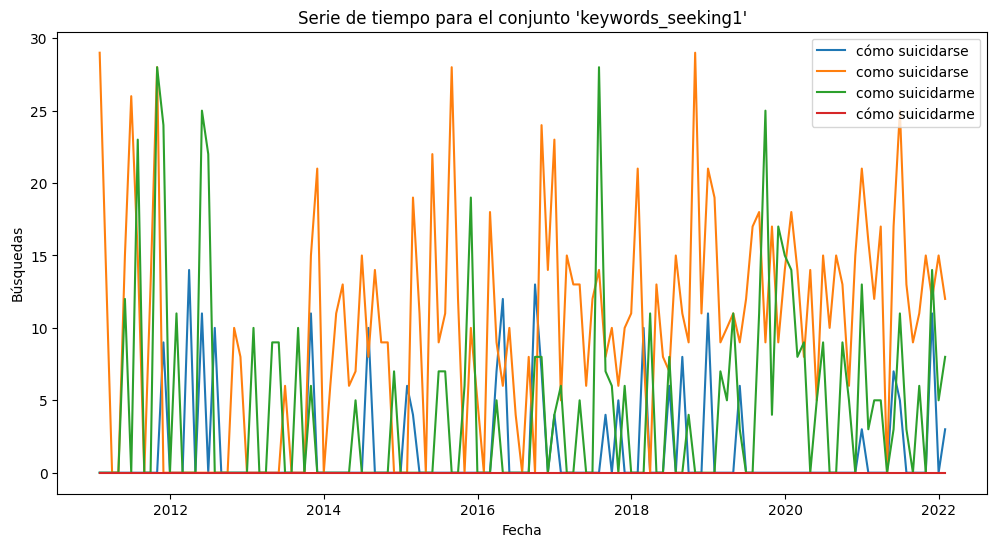

In [ ]:
subset_name = list(monthly_dfs.keys())[3]
subset_data = monthly_dfs[subset_name]

# Configura el tamaño de la figura
plt.figure(figsize=(12, 6))

# Itera a través de las columnas y traza cada una como una serie de tiempo
for column_name in subset_data.columns:
    plt.plot(subset_data.index, subset_data[column_name], label=column_name)

# Configura el título y las etiquetas de los ejes
plt.title(f"Serie de tiempo para el conjunto '{subset_name}'")
plt.xlabel("Fecha")
plt.ylabel("Búsquedas")

# Muestra una leyenda con los nombres de las categorías de búsqueda
plt.legend()

# Muestra el gráfico
plt.show()

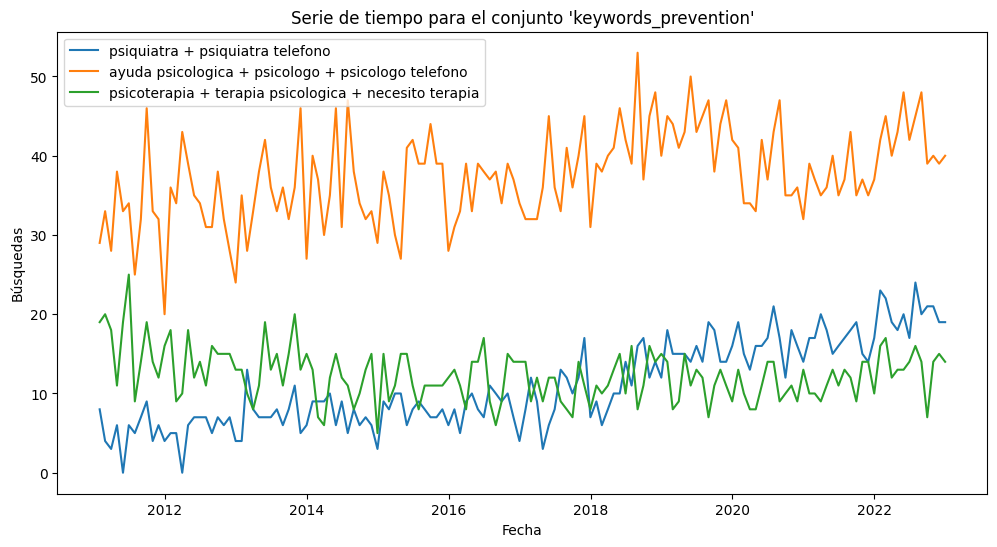

In [ ]:
subset_name = list(monthly_dfs.keys())[2]
subset_data = monthly_dfs[subset_name]

# Configura el tamaño de la figura
plt.figure(figsize=(12, 6))

# Itera a través de las columnas y traza cada una como una serie de tiempo
for column_name in subset_data.columns:
    plt.plot(subset_data.index, subset_data[column_name], label=column_name)

# Configura el título y las etiquetas de los ejes
plt.title(f"Serie de tiempo para el conjunto '{subset_name}'")
plt.xlabel("Fecha")
plt.ylabel("Búsquedas")

# Muestra una leyenda con los nombres de las categorías de búsqueda
plt.legend()

# Muestra el gráfico
plt.show()


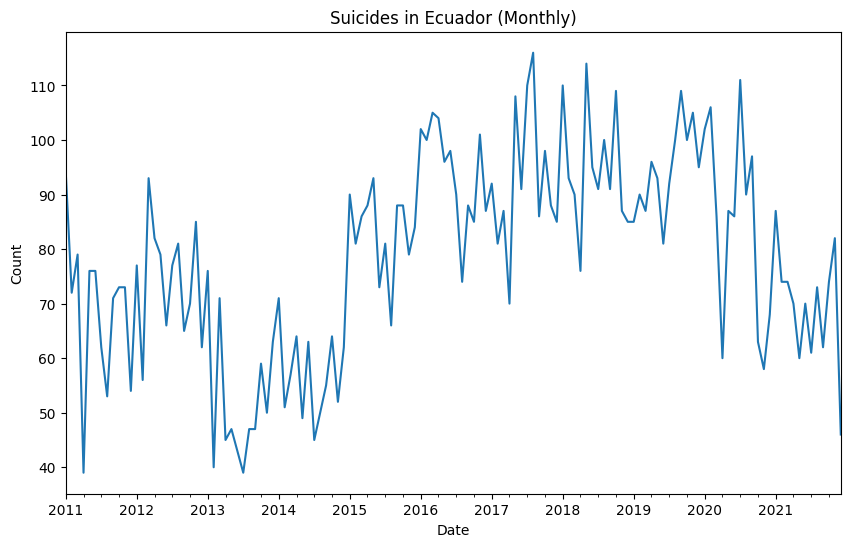

In [ ]:
df_monthly = df1.copy()
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_monthly = df_monthly[df_monthly['date'].dt.year >= 2011]
daily_counts = df_monthly.groupby('date').size()
monthly_counts = daily_counts.resample('M').sum()
monthly_counts.plot(kind='line', figsize=(10, 6))
plt.title('Suicides in Ecuador (Monthly)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(False)
plt.show()


In [ ]:
df_monthly.head(10)

,date,province,province_code,geometry,gender,age,age_range,description
0,2011-07-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",F,26,Adults (25-34),Self-poisoning
1,2011-08-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,23,Young adults (20-24),Self-poisoning
2,2012-06-28,Tungurahua,18,"POLYGON ((-78.40470 -0.98958, -78.40439 -0.991...",F,14,Pre-teens (10-14),Self-poisoning
3,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,21,Young adults (20-24),Self-poisoning
4,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,34,Adults (25-34),Self-poisoning
5,2012-04-28,Imbabura,10,"POLYGON ((-77.81272 0.35677, -77.81255 0.35653...",F,21,Young adults (20-24),Self-poisoning
6,2012-11-28,Pichincha,17,"POLYGON ((-79.01671 0.27237, -79.01677 0.27234...",M,35,Middle-aged adults (35-44),Self-poisoning
7,2012-02-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,66,Retirement age (65-74),Self-poisoning
8,2013-11-28,Napo,15,"POLYGON ((-77.30554 -0.05989, -77.30550 -0.060...",M,24,Young adults (20-24),Self-poisoning
9,2018-08-28,Carchi,04,"POLYGON ((-78.49647 1.19776, -78.49573 1.19763...",M,16,Teens (15-19),Self-poisoning


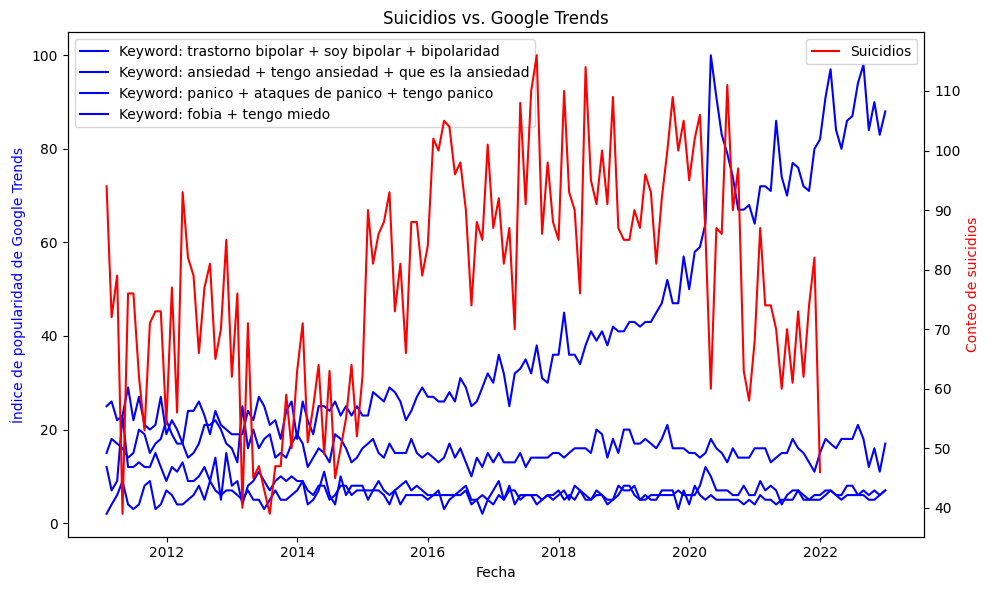

In [ ]:
# Crea la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Trama las series de búsqueda en Internet en azul
subset_name = list(monthly_dfs.keys())[3]
subset_data = monthly_dfs[subset_name]
for column_name in subset_data.columns:
    ax1.plot(subset_data.index, subset_data[column_name], color='blue', label=f'Keyword: {column_name}')

# Trama la serie de incidencia en rojo
ax2.plot(monthly_counts.index, monthly_counts, color='red', label='Suicidios')

# Configura los ejes y las etiquetas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Índice de popularidad de Google Trends', color='blue')
ax2.set_ylabel('Conteo de suicidios', color='red')

# Configura los títulos y las leyendas
ax1.set_title('Suicidios vs. Google Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajusta el diseño
fig.tight_layout()

# Muestra el gráfico
plt.show()


In [ ]:
# Crear una lista con los nombres de las series de búsqueda en Internet (azul)
series_azules = list(monthly_dfs[subset_name].columns)

# Crear una lista para almacenar los valores de correlación
correlation_values = []

# Iterar a través de las series azules y calcular la correlación con la serie de suicidios (rojo)
for column_name in series_azules:
    # Calcular la correlación de Pearson
    correlation = monthly_dfs[subset_name][column_name].corr(monthly_counts, method='pearson')

    # Agregar el resultado a la lista de valores de correlación
    correlation_values.append(correlation)

# Crear un DataFrame con los nombres de las series azules y sus correlaciones correspondientes
correlation_df = pd.DataFrame({'Serie Azul': series_azules, 'Correlación': correlation_values})

# Imprimir el DataFrame de correlaciones
print(correlation_df)



                                       Serie Azul  Correlación
0   trastorno bipolar + soy bipolar + bipolaridad    -0.333203
1  ansiedad + tengo ansiedad + que es la ansiedad     0.169927
2       panico + ataques de panico + tengo panico    -0.081869
3                             fobia + tengo miedo    -0.219236


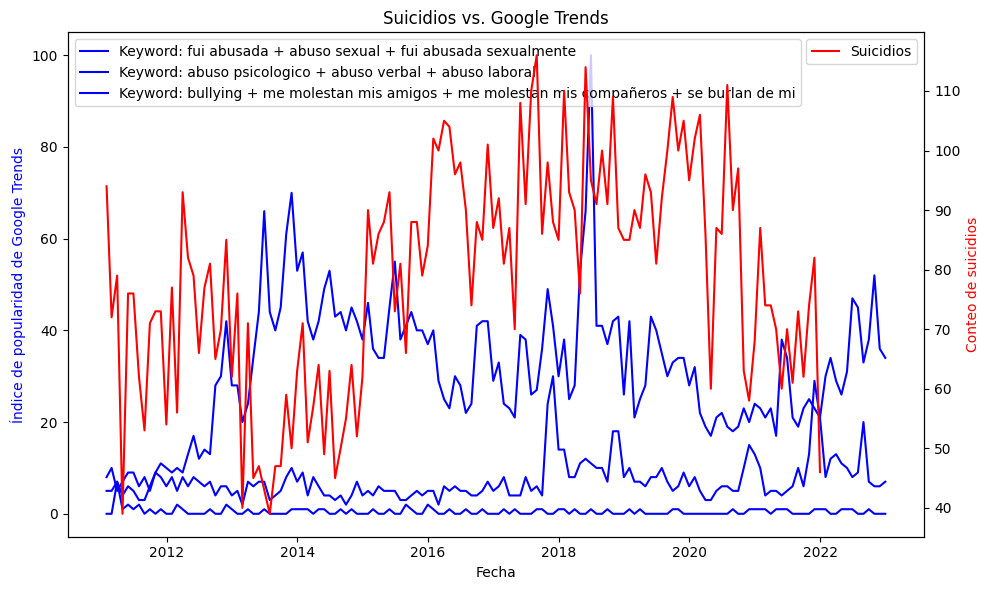

In [ ]:
# Crea la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Trama las series de búsqueda en Internet en azul
subset_name = list(monthly_dfs.keys())[5]
subset_data = monthly_dfs[subset_name]
for column_name in subset_data.columns:
    ax1.plot(subset_data.index, subset_data[column_name], color='blue', label=f'Keyword: {column_name}')

# Trama la serie de incidencia en rojo
ax2.plot(monthly_counts.index, monthly_counts, color='red', label='Suicidios')

# Configura los ejes y las etiquetas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Índice de popularidad de Google Trends', color='blue')
ax2.set_ylabel('Conteo de suicidios', color='red')

# Configura los títulos y las leyendas
ax1.set_title('Suicidios vs. Google Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajusta el diseño
fig.tight_layout()

# Muestra el gráfico
plt.show()

In [ ]:
# Crear una lista con los nombres de las series de búsqueda en Internet (azul)
series_azules = list(monthly_dfs[subset_name].columns)

# Crear una lista para almacenar los valores de correlación
correlation_values = []

# Iterar a través de las series azules y calcular la correlación con la serie de suicidios (rojo)
for column_name in series_azules:
    # Calcular la correlación de Pearson
    correlation = monthly_dfs[subset_name][column_name].corr(monthly_counts, method='pearson')

    # Agregar el resultado a la lista de valores de correlación
    correlation_values.append(correlation)

# Crear un DataFrame con los nombres de las series azules y sus correlaciones correspondientes
correlation_df = pd.DataFrame({'Serie Azul': series_azules, 'Correlación': correlation_values})

# Imprimir el DataFrame de correlaciones
print(correlation_df)

                                          Serie Azul  Correlación
0  fui abusada + abuso sexual + fui abusada sexua...     0.142253
1   abuso psicologico + abuso verbal + abuso laboral    -0.079449
2  bullying + me molestan mis amigos + me molesta...     0.010012


In [ ]:
# Función para calcular la correlación entre dos series
def calculate_correlation(series1, series2):
    if len(series1) < 2 or len(series2) < 2:
        return None
    correlation, p_value = stats.pearsonr(series1, series2)
    return correlation if p_value < 0.05 else None

# Función para iterar a través de los filtros y calcular la correlación
def iterate_filters_and_calculate_correlation(filter_column):
    results = []
    for filter_value, filter_data in df1[df1['date'].dt.year >= 2008].groupby(filter_column):
        # Agrupa y suma los datos por mes
        monthly_counts = filter_data.groupby('date').size().resample('M').sum()
        for subset_name, trend_data in monthly_dfs.items():
            # Unifica las series de tendencias de búsqueda en una serie sumada
            unified_trend_series = trend_data.sum(axis=1)
            # Ambas series deben tener el mismo índice y la misma longitud
            common_index = monthly_counts.index.intersection(unified_trend_series.index)
            monthly_counts_reindexed = monthly_counts.reindex(common_index, fill_value=0)
            unified_trend_series_reindexed = unified_trend_series.reindex(common_index, fill_value=0)
            correlation_value = calculate_correlation(monthly_counts_reindexed, unified_trend_series_reindexed)
            if correlation_value is not None:  # Solo agrega resultados si hay una correlación significativa
                results.append({'filter': f'{filter_column}: {filter_value}', 'keyword_subset': subset_name, 'correlation': correlation_value})
    return pd.DataFrame(results)

# Llama a la función para cada tipo de filtro
gender_results_df = iterate_filters_and_calculate_correlation('gender')
age_range_results_df = iterate_filters_and_calculate_correlation('age_range')
province_results_df = iterate_filters_and_calculate_correlation('province')



In [ ]:
gender_results_df

,filter,keyword_subset,correlation
0,gender: F,keywords_mood,-0.194289
1,gender: F,keywords_lgbti,-0.183932
2,gender: M,keywords_neutral,-0.499767
3,gender: M,keywords_search,-0.574832
4,gender: M,keywords_prevention,0.369861
5,gender: M,keywords_mood,0.175660


In [ ]:
age_range_results_df

,filter,keyword_subset,correlation
0,age_range: Children (5-9),keywords_mood,0.330113
1,age_range: Children (5-9),keywords_stress,0.256067
2,age_range: Pre-teens (10-14),keywords_neutral,-0.196446
3,age_range: Pre-teens (10-14),keywords_search,-0.198849
4,age_range: Teens (15-19),keywords_mood,-0.245018
5,age_range: Young adults (20-24),keywords_neutral,-0.216578
6,age_range: Young adults (20-24),keywords_search,-0.223678
7,age_range: Adults (25-34),keywords_neutral,-0.293282
8,age_range: Adults (25-34),keywords_search,-0.372765
9,age_range: Adults (25-34),keywords_prevention,0.216668


In [ ]:
province_results_df

,filter,keyword_subset,correlation
0,province: Azuay,keywords_neutral,-0.300650
1,province: Azuay,keywords_prevention,0.203426
2,province: Bolívar,keywords_mood,-0.190741
3,province: Chimborazo,keywords_neutral,-0.259899
4,province: Chimborazo,keywords_search,-0.226633
5,province: El Oro,keywords_neutral,-0.249043
6,province: El Oro,keywords_search,-0.276004
7,province: El Oro,keywords_prevention,0.229763
8,province: El Oro,keywords_mood,0.247138
9,province: El Oro,keywords_lgbti,0.208876


In [ ]:
# Función para calcular la correlación entre dos series con un rezago especificado
def calculate_correlation2(series1, series2, lag):
    if len(series1) < 2 or len(series2) < 2:
        return None
    series2_lagged = series2.shift(lag).dropna()
    series1_truncated = series1.iloc[:len(series2_lagged)]
    correlation, p_value = stats.pearsonr(series1_truncated, series2_lagged)
    return correlation if p_value < 0.05 else None

# Función para iterar a través de los filtros y calcular la correlación con varios rezagos
def iterate_filters_and_calculate_correlation2(filter_column):
    results = []
    for filter_value, filter_data in df1[df1['date'].dt.year >= 2008].groupby(filter_column):
        # Agrupa y suma los datos por mes
        monthly_counts = filter_data.groupby('date').size().resample('M').sum()
        for subset_name, trend_data in monthly_dfs.items():
            # Unifica las series de tendencias de búsqueda en una serie sumada
            unified_trend_series = trend_data.sum(axis=1)
            # Ambas series deben tener el mismo índice y la misma longitud
            common_index = monthly_counts.index.intersection(unified_trend_series.index)
            monthly_counts_reindexed = monthly_counts.reindex(common_index, fill_value=0)
            unified_trend_series_reindexed = unified_trend_series.reindex(common_index, fill_value=0)
            # Calcula y almacena la correlación para cada rezago
            correlations = {
                'filter': f'{filter_column}: {filter_value}',
                'keyword_subset': subset_name
            }
            for lag in range(1, 4):  # rezagos 1, 2, 3
                correlation_value = calculate_correlation2(monthly_counts_reindexed, unified_trend_series_reindexed, lag)
                correlations[f'correlation_lag_{lag}'] = correlation_value
            results.append(correlations)
    return pd.DataFrame(results)

# Llama a la función para cada tipo de filtro
gender_results_df2 = iterate_filters_and_calculate_correlation2('gender')
age_range_results_df2 = iterate_filters_and_calculate_correlation2('age_range')
province_results_df2 = iterate_filters_and_calculate_correlation2('province')


In [ ]:
gender_results_df2

,filter,keyword_subset,correlation_lag_1,correlation_lag_2,correlation_lag_3
0,gender: F,keywords_neutral,NaN,NaN,NaN
1,gender: F,keywords_search,NaN,NaN,NaN
2,gender: F,keywords_prevention,NaN,NaN,NaN
3,gender: F,keywords_mood,NaN,-0.186892,-0.193832
4,gender: F,keywords_stress,NaN,NaN,NaN
5,gender: F,keywords_traumas,NaN,NaN,NaN
6,gender: F,keywords_lgbti,-0.199680,-0.195778,-0.196293
7,gender: F,keywords_ethnics,NaN,NaN,NaN
8,gender: M,keywords_neutral,-0.505612,-0.510650,-0.515962
9,gender: M,keywords_search,-0.588082,-0.589805,-0.593660


In [ ]:
age_range_results_df2

,filter,keyword_subset,correlation_lag_1,correlation_lag_2,correlation_lag_3
0,age_range: Infants and toddlers (0-4),keywords_neutral,NaN,NaN,NaN
1,age_range: Infants and toddlers (0-4),keywords_search,NaN,NaN,NaN
2,age_range: Infants and toddlers (0-4),keywords_prevention,NaN,NaN,NaN
3,age_range: Infants and toddlers (0-4),keywords_mood,NaN,NaN,NaN
4,age_range: Infants and toddlers (0-4),keywords_stress,NaN,NaN,NaN
...,...,...,...,...,...
91,age_range: Very elderly (+85),keywords_mood,NaN,NaN,NaN
92,age_range: Very elderly (+85),keywords_stress,NaN,NaN,NaN
93,age_range: Very elderly (+85),keywords_traumas,0.183978,0.18106,0.177428
94,age_range: Very elderly (+85),keywords_lgbti,NaN,NaN,NaN


In [ ]:
province_results_df2

,filter,keyword_subset,correlation_lag_1,correlation_lag_2,correlation_lag_3
0,province: Azuay,keywords_neutral,-0.302968,-0.296374,-0.293429
1,province: Azuay,keywords_search,NaN,NaN,NaN
2,province: Azuay,keywords_prevention,NaN,NaN,NaN
3,province: Azuay,keywords_mood,NaN,NaN,NaN
4,province: Azuay,keywords_stress,NaN,NaN,NaN
...,...,...,...,...,...
203,province: Zonas no delimitadas,keywords_mood,NaN,NaN,NaN
204,province: Zonas no delimitadas,keywords_stress,NaN,NaN,NaN
205,province: Zonas no delimitadas,keywords_traumas,NaN,NaN,NaN
206,province: Zonas no delimitadas,keywords_lgbti,NaN,NaN,NaN
